In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
from matplotlib.colors import ListedColormap
from scipy.spatial import distance
from scipy.stats import wasserstein_distance
from itertools import chain
from numpy import linalg as LA
import sklearn.preprocessing as preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
import math
import random
import copy
from sklearn.model_selection import cross_val_score, cross_validate, KFold
import lightgbm as lgb
import joblib
import shap
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score, confusion_matrix
import scipy.stats as ss


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load real and synthetic data

In [3]:
# load real data
real_data_df = pd.read_csv('/u/student/2024/cs24btnsr11002/2.0/saved_dataset/original_training_data.csv') # note this is the training data for GAN training (not include the test data)
min_max_log = np.load('/u/student/2024/cs24btnsr11002/2.0/training/min_max_log.npy', allow_pickle=True).item()
# for key, min_max in min_max_log.items():
#     min_, max_ = min_max[0], min_max[1]
#     col_values = np.array(real_data_df[key])
#     real_data_df[key] = (1 - col_values)*max_ + col_values*min_
condition_columns = list(real_data_df.columns)[8:-4]
# real_data_df

In [4]:
min_max_log

{'AGE': [np.int64(18), np.int64(91)],
 'BMI': [np.float64(10.0), np.float64(60.0)],
 'DIASTOLIC': [np.float64(30.0), np.float64(168.0)],
 'SYSTOLIC': [np.float64(56.0), np.float64(244.0)]}

In [5]:
print(np.sum(real_data_df['WHITE']))
print(np.sum(real_data_df['BLACK']))
print(np.sum(real_data_df['ASIAN']))
print(np.sum(real_data_df['HISPANIC']))
print(np.sum(real_data_df['UN']))
print(np.sum(real_data_df['OTHER']))
print('Num of y-positive record %d' % np.sum(real_data_df['DIE_1y']))
print('Num of y-negative record %d' % (len(real_data_df) - np.sum(real_data_df['DIE_1y'])))

98386.0
19300.0
6490.0
8242.0
6990.0
8352.0
Num of y-positive record 17640
Num of y-negative record 130120


In [6]:
# load synthetic data
col_name_list = list(real_data_df.columns)

model_id_list = ['m1']
ckpt_id_list = ['2450']


syn_data_list = []

for model_id, ckpt_id in zip(model_id_list, ckpt_id_list):
    
    syn_data = np.load(f'/u/student/2024/cs24btnsr11002/2.0/training/GAN_training/syn/emrwgan_model_{model_id}_ckpt_{ckpt_id}.npy',allow_pickle=False)
    for i in range(len(col_name_list)-4):
        syn_data[:,i] = (syn_data[:,i] >= 0.5)*1.0
    syn_data_df = pd.DataFrame(syn_data, columns = col_name_list)
    positive_outcome_syn_data = syn_data_df[syn_data_df['DIE_1y'] == 1.0].values
    negative_outcome_syn_data = syn_data_df[syn_data_df['DIE_1y'] == 0.0].values
    syn_data_df = np.concatenate((positive_outcome_syn_data[:14243,:], negative_outcome_syn_data[:112279,:]), axis=0)
    syn_data_df = pd.DataFrame(syn_data_df, columns = col_name_list)
    
    syn_data_list.append(syn_data_df.values)
    
    
    

In [7]:
syn_data_df.head()

,WHITE,BLACK,ASIAN,HISPANIC,UN,OTHER,DIE_1y,GENDER,008,008.5,...,985,987,988,989,990,994,AGE,BMI,DIASTOLIC,SYSTOLIC
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,78.685043,24.258970,96.070374,127.425713
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,86.909996,13.094635,58.540581,79.135574
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,78.931183,53.483421,110.164780,130.875595
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,60.730347,40.775547,61.380165,135.807343
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,89.358871,12.166824,53.078819,147.047028


In [8]:
print(np.sum(syn_data_df['WHITE']))
print(np.sum(syn_data_df['BLACK']))
print(np.sum(syn_data_df['ASIAN']))
print(np.sum(syn_data_df['HISPANIC']))
print(np.sum(syn_data_df['UN']))
print(np.sum(syn_data_df['OTHER']))

83660.0
16294.0
5798.0
7355.0
6123.0
7292.0


findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.


findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

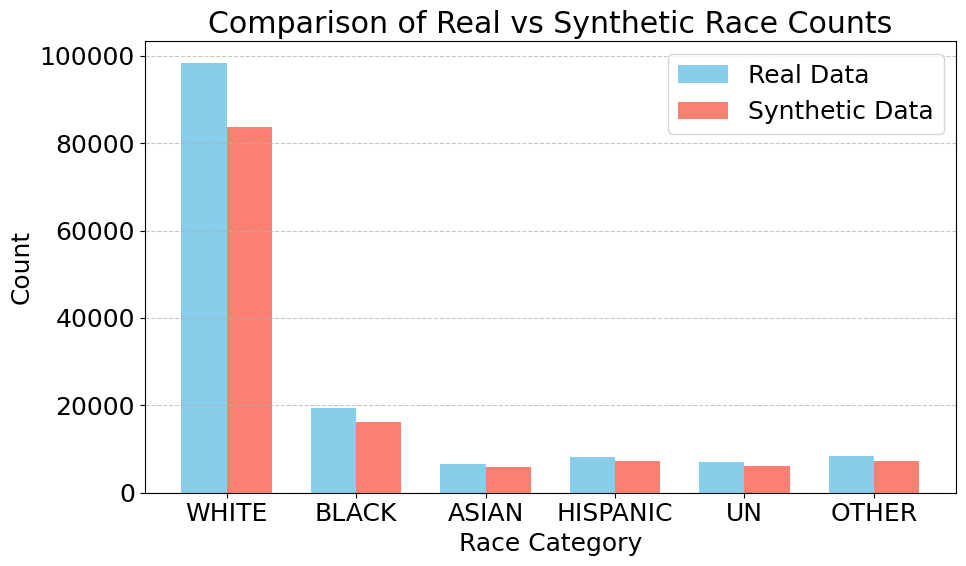

In [54]:
import numpy as np
import matplotlib.pyplot as plt

# Replace these with your actual values
real_counts = [
    np.sum(real_data_df['WHITE']),
    np.sum(real_data_df['BLACK']),
    np.sum(real_data_df['ASIAN']),
    np.sum(real_data_df['HISPANIC']),
    np.sum(real_data_df['UN']),
    np.sum(real_data_df['OTHER'])
]

synthetic_counts = [
    np.sum(syn_data_df['WHITE']),
    np.sum(syn_data_df['BLACK']),
    np.sum(syn_data_df['ASIAN']),
    np.sum(syn_data_df['HISPANIC']),
    np.sum(syn_data_df['UN']),
    np.sum(syn_data_df['OTHER'])
]
categories = ['WHITE', 'BLACK', 'ASIAN', 'HISPANIC', 'UN', 'OTHER']
# Bar positions
x = np.arange(len(categories))
width = 0.35  # width of the bars

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, real_counts, width, label='Real Data', color='skyblue')
plt.bar(x + width/2, synthetic_counts, width, label='Synthetic Data', color='salmon')

# Labels and title
plt.xlabel('Race Category')
plt.ylabel('Count')
plt.title('Comparison of Real vs Synthetic Race Counts')
plt.xticks(x, categories)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()

In [9]:
utility_score = {}
privacy_score = {}

# Data utility evaluation 

## 1. Utility Metrics

### 1.a Dimension-wise distribution

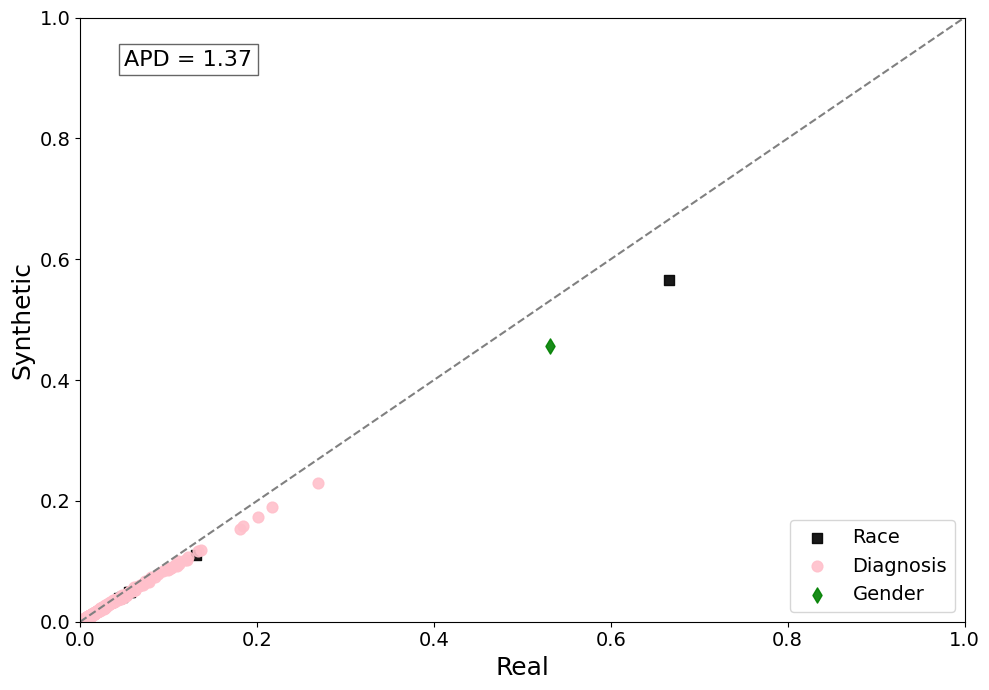

In [17]:
import numpy as np
import matplotlib.pyplot as plt

binary_perc_real = []
FEATURE_COUNT = len(syn_data_df.columns) - 4
train_data = real_data_df.values

for c in range(0, FEATURE_COUNT):
    if c != 6:
        binary_perc_real.append(np.sum(train_data[:, c]) / train_data.shape[0])

# Use only one synthetic dataset, for example the first one
syn_data = syn_data_list[0]
binary_perc_syn = []

for c in range(0, FEATURE_COUNT):
    if c != 6:
        binary_perc_syn.append(np.sum(syn_data[:, c]) / train_data.shape[0])

# Feature clusters: 0 = Race, 1 = Diagnosis, 2 = Gender
cluster_list = np.array([0] * 6 + [2] + [1] * len(condition_columns))

# Calculate metrics
sd2d = np.sum(abs(np.array(binary_perc_syn) - np.array(binary_perc_real)))
ad2d = np.sum(abs(np.array(binary_perc_syn) - np.array(binary_perc_real))) / FEATURE_COUNT * 1000.0

# Create one plot
fig, ax = plt.subplots(figsize=(10, 7))
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel("Real", fontsize=18)
ax.set_ylabel("Synthetic", fontsize=18)
ax.tick_params(labelsize=14)

# Plot points with color/marker based on cluster
for index, marker, color, label in zip([0, 1, 2], ["s", "o", "d"], ['black', 'pink', 'green'], ['Race', 'Diagnosis', 'Gender']):
    ax.scatter(
        np.array(binary_perc_real)[cluster_list == index],
        np.array(binary_perc_syn)[cluster_list == index],
        color=color,
        s=60,
        label=label,
        marker=marker,
        alpha=0.9
    )

# Reference diagonal
ax.plot([0, 1], [0, 1], ls="--", c="gray")

# Annotation for AD2D value
ax.text(0.05, 0.92, f'APD = {ad2d:.2f}', fontsize=16, bbox=dict(facecolor='white', alpha=0.6))

# Legend and show
ax.legend(fontsize=14)
plt.tight_layout()
plt.show()


18.0
91.0
10.2
60.0
30.0
168.0
56.0
244.0

 AGE


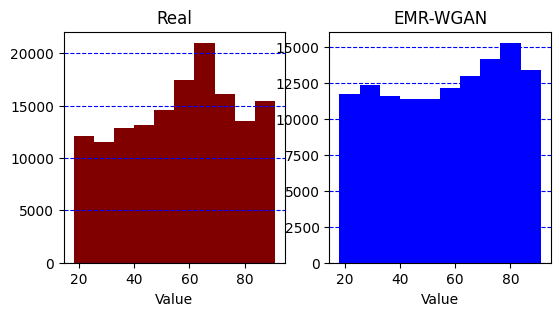

EMR-WGAN : mean: 1.6331, std: 0.0000

 BMI


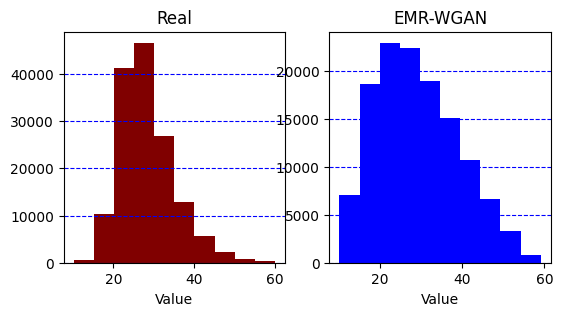

EMR-WGAN : mean: 3.0753, std: 0.0000

 DIASTOLIC


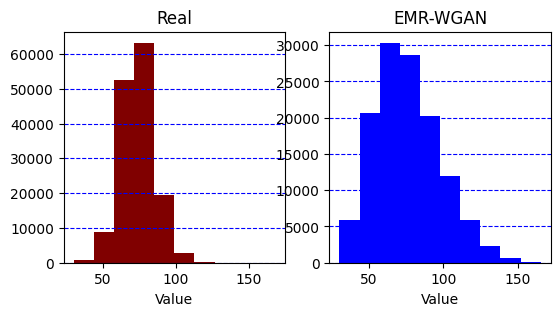

EMR-WGAN : mean: 8.2497, std: 0.0000

 SYSTOLIC


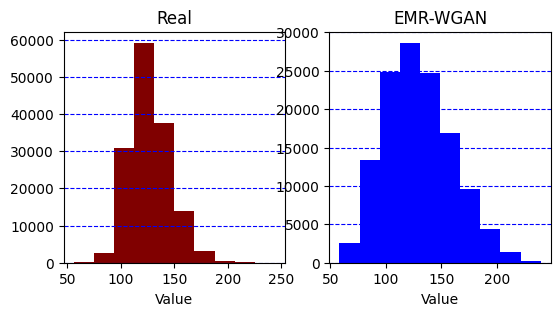

EMR-WGAN : mean: 10.1735, std: 0.0000
{'AGE': [np.float64(1.6330820112206934)], 'BMI': [np.float64(3.0752798190276165)], 'DIASTOLIC': [np.float64(8.24971853767185)], 'SYSTOLIC': [np.float64(10.173494755675637)]}


In [14]:
## Dimension-wise distribution: continuous features

print(np.min(list(real_data_df['AGE'])))
print(np.max(list(real_data_df['AGE'])))

print(np.min(list(real_data_df['BMI'])))
print(np.max(list(real_data_df['BMI'])))

print(np.min(list(real_data_df['DIASTOLIC'])))
print(np.max(list(real_data_df['DIASTOLIC'])))

print(np.min(list(real_data_df['SYSTOLIC'])))
print(np.max(list(real_data_df['SYSTOLIC'])))

continuous_w_d = {}
continuous_columns = ['AGE', 'BMI', 'DIASTOLIC', 'SYSTOLIC']

RUN_list = [1]

for column in continuous_columns:
    distances_to_real = []

    model_list_figure = ['Real']
    real_values = list(real_data_df[column])
    data_list = [real_values]
    color_list = ['maroon']
    for run in RUN_list:
        emrwgan_df = pd.DataFrame(syn_data_list[run-1], columns = list(real_data_df.columns))
        data_list.append(list(emrwgan_df[column]))
        color_list.append('blue')
        model_list_figure.append('EMR-WGAN')
    
    fig = plt.figure(figsize=(20, 3))
    
    print('\n %s' % column)
    for subplot_count in range(len(data_list)):
        
        if subplot_count > 0:
            distances_to_real.append(wasserstein_distance(real_values, data_list[subplot_count]))
        
        plt.subplot(1, 6, subplot_count+1)
        # fig = plt.figure(figsize = (3, 5))
        plt.hist(data_list[subplot_count], color = color_list[subplot_count])
        plt.xlabel("Value")
#         plt.ylim(0, 10000)
        plt.title(model_list_figure[subplot_count])
        plt.grid(color = 'blue', linestyle = '--', axis = 'y')

    plt.show()
    print("EMR-WGAN : mean: %.4f, std: %.4f" % (np.mean(distances_to_real), np.std(distances_to_real)))

    continuous_w_d[column] = distances_to_real
print(continuous_w_d)

In [18]:
continuous_value = {}
norm_continuous_value = {}
    
for test, w_d in continuous_w_d.items():
    w_d = list(w_d)
    max_val = np.max(w_d)
    min_val = np.min(w_d)
    norm_w_d = (w_d - min_val) / (max_val-min_val) / 10
    continuous_value[test] = w_d
    norm_continuous_value[test] = list(norm_w_d)
    
continuous_value_df = pd.DataFrame.from_dict(continuous_value)
norm_continuous_value_df = pd.DataFrame.from_dict(norm_continuous_value)
sum_all_continuous_variables = np.sum(norm_continuous_value_df.values, axis = 1)
print(sum_all_continuous_variables)
norm_continuous_value_df

[nan]


/tmp/ipykernel_1493700/922827670.py:8: RuntimeWarning: invalid value encountered in divide
  norm_w_d = (w_d - min_val) / (max_val-min_val) / 10


,AGE,BMI,DIASTOLIC,SYSTOLIC
0,NaN,NaN,NaN,NaN


In [19]:
combine_score_binary_cont = []
for run in RUN_list:
    combine_score_binary_cont.append((sd2d_result[run-1] + sum_all_continuous_variables[run-1])/(len(real_data_df.columns)-1) * 1000)

print('Dimension-wise distribution scores for all considered runs:', combine_score_binary_cont)
utility_score['Dimension-wise distribution'] = combine_score_binary_cont



IndexError: list index out of range

### 1.b Column-wise correlation

In [20]:
real_cor = np.corrcoef(np.transpose(train_data))
cwc = []
print("Column-wise correlation difference: \n")
for matrix in syn_data_list:
    np.random.seed(0)
    noise_matrix = (np.random.rand(len(matrix),len(matrix[0])) - 1) / 100000000    
    syn_cor = np.corrcoef(np.transpose(np.array(matrix) + noise_matrix))
    cwc.append(LA.norm(real_cor - syn_cor, 'fro') / len(real_data_df.columns) / len(real_data_df.columns) * 1000 * 1000)

print(cwc)
utility_score['Column-wise correlation'] = cwc


Column-wise correlation difference: 

[np.float64(7.714727635338697)]


In [21]:
syn_data_list[0][0]

array([  1.     ,   0.     ,   0.     , ...,  24.25897,  96.07037,
       127.42571], dtype=float32)

### 1.c Latent cluster analysis

In [22]:
min_max_scaler = preprocessing.MinMaxScaler()
train_data_tmp = copy.deepcopy(train_data)
train_data_df = pd.DataFrame(train_data_tmp)
train_data_df.loc[:,[1456, 1457, 1458, 1459]] = min_max_scaler.fit_transform(train_data_df[[1456, 1457, 1458, 1459]].values)
NUM_C = 5 ## the number of clusters which has been optimized


In [23]:
real_data_df

,WHITE,BLACK,ASIAN,HISPANIC,UN,OTHER,DIE_1y,GENDER,008,008.5,...,985,987,988,989,990,994,AGE,BMI,DIASTOLIC,SYSTOLIC
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,77.0,19.4,74.0,156.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,73.0,26.3,66.0,131.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,33.0,21.1,65.0,140.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,65.0,21.2,88.0,105.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,45.0,24.2,65.0,98.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147755,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,24.0,29.5,70.0,124.0
147756,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,35.0,25.0,60.0,98.0
147757,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,46.0,21.9,80.0,90.0
147758,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,86.0,27.2,72.0,123.0


In [24]:
max(real_data_df['AGE'])

91.0

In [25]:
log_cluster_score_list = []
print("Latent deviation: \n")
for matrix in syn_data_list:
    matrix_df = pd.DataFrame(copy.deepcopy(matrix))
    matrix_df.loc[:,[1456, 1457, 1458, 1459]] = min_max_scaler.fit_transform(matrix_df[[1456, 1457, 1458, 1459]].values)
    mixed_data = np.concatenate((train_data_df.values,matrix_df.values), axis = 0)
    pca = PCA()
    pca_result = pca.fit_transform(mixed_data)
    sum_diag = np.sum(pca.explained_variance_ratio_)
    i = 1
    while  np.sum(pca.explained_variance_ratio_[:i]) < 0.8:
        i += 1
#     print(i, np.sum(pca.explained_variance_ratio_[:i])/np.sum(pca.explained_variance_ratio_))
    pca = PCA(n_components=i)
    pca_result = pca.fit_transform(mixed_data)
    
    kmeans_model = KMeans(n_clusters=NUM_C).fit(pca_result)
    cluster_aff = kmeans_model.labels_.tolist()
    real_syn_label = [1]*len(train_data_df.values) + [0]*len(matrix_df.values)
    
    cluster_score_sum = 0
    for label in range(NUM_C):
        indices_label = [i for i in range(len(cluster_aff)) if cluster_aff[i] == label]
        real_syn_for_label = [real_syn_label[i] for i in indices_label]
        ratio = np.sum(real_syn_for_label)/len(real_syn_for_label)
        cluster_score_sum += (ratio - 0.5)**2
    log_cluster_score_list.append(math.log2(cluster_score_sum/NUM_C))
print(log_cluster_score_list)
utility_score['Latent cluster analysis'] = log_cluster_score_list


Latent deviation: 

[-5.996766469604482]


### 1.d Medical concept abundance

Medical concept abundance distances: [np.float64(0.07553465078505685)]


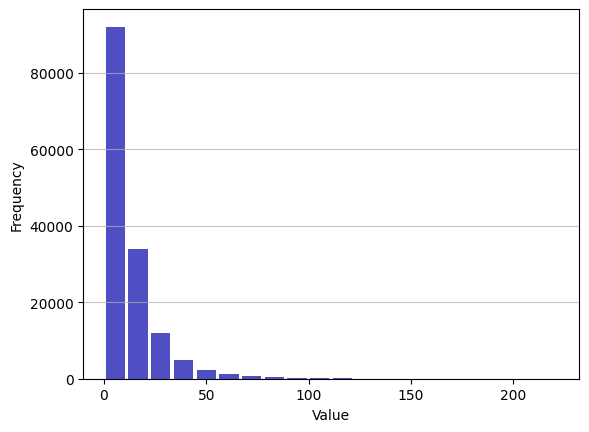

In [26]:
mca_train_data_df = real_data_df[condition_columns]
mca_train_data = np.sum(mca_train_data_df.values, axis=1)
n, bins, patches = plt.hist(x=mca_train_data, bins=20, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')

mca_syn_data_list = []

for matrix in syn_data_list:
    syn_data_df = pd.DataFrame(data = matrix, columns = list(real_data_df.columns))
    mca_syn_data_df = syn_data_df[condition_columns]
    mca_syn_data = np.sum(mca_syn_data_df.values, axis=1).astype(int)
    count_in_bins = {}

    bin_counts = [0]*len(n) 
    for data_point in mca_syn_data:
        bin_number = data_point // (bins[1]-bins[0])
        if bin_number >= len(n):
            bin_counts[-1] += 1
        else:
            bin_counts[int(bin_number)] += 1

    mca_syn_data_list.append(np.sum(np.abs(np.array(bin_counts)-n))*0.5/len(mca_train_data))

print("Medical concept abundance distances:", mca_syn_data_list)
utility_score['Medical concept abundance'] = mca_syn_data_list


### 1.e Clinical knowledge violation

In [27]:
disease_male_dict = {}
disease_female_dict = {}

gender_column = real_data_df['GENDER'].tolist()
for column in condition_columns:
    disease_column = real_data_df[column].tolist()
    patient_positive = [index for index in range(len(disease_column)) if disease_column[index] == 1]
    gender_positive_patient = [gender_column[index] for index in patient_positive]
    if np.sum(gender_positive_patient) == 0: # male
        disease_male_dict[column] = len(patient_positive)
    if np.sum(gender_positive_patient) == len(gender_positive_patient): # female
        disease_female_dict[column] = len(patient_positive)

    
sorted_disease_female_dict = sorted(disease_female_dict.items(), key=lambda kv: kv[1], reverse=True)
sorted_disease_male_dict = sorted(disease_male_dict.items(), key=lambda kv: kv[1], reverse=True)

In [28]:
# male: 600: Hyperplasia of prostate
# male: 185: Cancer of prostate
# male: 605: Erectile dysfunction [ED]

# female: 649: Other conditions or status of the mother complicating pregnancy, childbirth, or the puerperium
# female: 655: Known or suspected fetal abnormality affecting management of mother
# female: 646: Other complications of pregnancy NEC

print('    Male codes: ')
for code in ['600', '185', '605']:
    disease_column = real_data_df[code].tolist()
    patient_positive = [index for index in range(len(disease_column)) if disease_column[index] == 1]
    gender_column = real_data_df['GENDER'].tolist()
    gender_positive_patient = [gender_column[index] for index in patient_positive]
    print('       ' + code + ': # total patients = ' + str(np.sum(disease_column)) + '; male percentage: ' + str((len(gender_positive_patient) - np.sum(gender_positive_patient))/len(gender_positive_patient)) + '; female percentage: ' + str(np.sum(gender_positive_patient)/len(gender_positive_patient)))

print('    Female codes: ')
for code in ['649', '655', '646']:
    disease_column = real_data_df[code].tolist()
    patient_positive = [index for index in range(len(disease_column)) if disease_column[index] == 1]
    gender_column = real_data_df['GENDER'].tolist()
    gender_positive_patient = [gender_column[index] for index in patient_positive]
    print('       ' + code + ': # total patients = ' + str(np.sum(disease_column)) + '; male percentage: ' + str((len(gender_positive_patient) - np.sum(gender_positive_patient))/len(gender_positive_patient)) + '; female percentage: ' + str(np.sum(gender_positive_patient)/len(gender_positive_patient)))


    Male codes: 
       600: # total patients = 4237.0; male percentage: 1.0; female percentage: 0.0
       185: # total patients = 3073.0; male percentage: 1.0; female percentage: 0.0
       605: # total patients = 371.0; male percentage: 1.0; female percentage: 0.0
    Female codes: 
       649: # total patients = 4755.0; male percentage: 0.0; female percentage: 1.0
       655: # total patients = 3920.0; male percentage: 0.0; female percentage: 1.0
       646: # total patients = 3375.0; male percentage: 0.0; female percentage: 1.0


In [29]:
run = 1
male_code_violation = []
female_code_violation = []
for matrix in syn_data_list:
    syn_data_df = pd.DataFrame(data = matrix, columns = list(real_data_df.columns))
    print('\nSynthetic data ' + str(run) + ':')
    print('    Male codes: ')
    male_viol_sum = 0
    for code in ['600', '185', '605']:
        disease_column = syn_data_df[code].tolist()
        patient_positive = [index for index in range(len(disease_column)) if disease_column[index] == 1]
        gender_column = syn_data_df['GENDER'].tolist()
        gender_positive_patient = [gender_column[index] for index in patient_positive]
        print('       ' + code + ': # total patients = ' + str(np.sum(disease_column)) + '; male percentage: ' + str((len(gender_positive_patient) - np.sum(gender_positive_patient))/len(gender_positive_patient)) + '; female percentage: ' + str(np.sum(gender_positive_patient)/len(gender_positive_patient)))
        male_viol_sum += np.sum(gender_positive_patient)/len(gender_positive_patient)
    male_code_violation.append(male_viol_sum/3)
    
    print('    Female codes: ')
    female_viol_sum = 0
    for code in ['649', '655', '646']:
        disease_column = syn_data_df[code].tolist()
        patient_positive = [index for index in range(len(disease_column)) if disease_column[index] == 1]
        gender_column = syn_data_df['GENDER'].tolist()
        gender_positive_patient = [gender_column[index] for index in patient_positive]
        print('       ' + code + ': # total patients = ' + str(np.sum(disease_column)) + '; male percentage: ' + str((len(gender_positive_patient) - np.sum(gender_positive_patient))/len(gender_positive_patient)) + '; female percentage: ' + str(np.sum(gender_positive_patient)/len(gender_positive_patient)))
        female_viol_sum += (len(gender_positive_patient) - np.sum(gender_positive_patient))/len(gender_positive_patient)
    female_code_violation.append(female_viol_sum/3)
    
    run += 1
    
utility_score['Clinical knowledge violation'] = np.array(male_code_violation) + np.array(female_code_violation)
print('Clinical knowledge violation: male code violation ', male_code_violation, 'female code violation ', female_code_violation)
print('Combined violation: ', np.array(male_code_violation) + np.array(female_code_violation))



Synthetic data 1:
    Male codes: 
       600: # total patients = 3871.0; male percentage: 0.9423921467321106; female percentage: 0.05760785326788943
       185: # total patients = 2803.0; male percentage: 0.897966464502319; female percentage: 0.10203353549768106
       605: # total patients = 227.0; male percentage: 0.9955947136563876; female percentage: 0.004405286343612335
    Female codes: 
       649: # total patients = 4502.0; male percentage: 0.015770768547312304; female percentage: 0.9842292314526877
       655: # total patients = 3798.0; male percentage: 0.010005265929436546; female percentage: 0.9899947340705635
       646: # total patients = 3268.0; male percentage: 0.006731946144430845; female percentage: 0.9932680538555692
Clinical knowledge violation: male code violation  [np.float64(0.05468222503639428)] female code violation  [np.float64(0.010835993540393232)]
Combined violation:  [0.06551822]


### 1.f TSTR

In [31]:
import os
os.makedirs('./result', exist_ok=True)  # 🔒 ensures directory exists



## Train on real training dataset and test on real testing data set

random.seed(a=2021, version=2)

RECALL_THRESHOLD = 0.6  # hold this to compute other threshold related metrics
LABEL_INDEX = 6  # label column index in the dataset
RACE_COL = [0,1,2,3,4,5]
COL_LIST = list(real_data_df.columns)[len(RACE_COL)+1:]
CAT_IDX_wo_RACE_label = list(np.linspace(0, len(COL_LIST) - 5, num=len(COL_LIST) - 4).astype(int))

## Load the dataset for model training. Here it is real data. 70%
train_real_data = pd.read_csv('/u/student/2024/cs24btnsr11002/2.0/saved_dataset/original_training_data.csv').values.astype(np.float64)
train_real_data_index = np.linspace(0,len(train_real_data)-1,len(train_real_data)).astype('int')
random.shuffle(train_real_data_index)
train_real_data = train_real_data[train_real_data_index]
train_real_label = train_real_data[:,LABEL_INDEX].astype(np.float64)
train_real_data = np.delete(train_real_data, [LABEL_INDEX]+RACE_COL, axis = 1)
print('The number of records in training (real) data is:  %d' % len(train_real_data))
print('The number of features in training (real) data is:  %d' % len(train_real_data[0]))
print('Positive vs Negative ratio in training (real) data is: %f' % (np.sum(train_real_label)/len(train_real_label)))

## load the dataset for model evaluation. Here it is real data. 30%
eval_real_data = pd.read_csv('/u/student/2024/cs24btnsr11002/2.0/saved_dataset/original_testing_data.csv').values.astype(np.float64)
eval_real_label = eval_real_data[:,LABEL_INDEX].astype(np.float64)
eval_real_data = np.delete(eval_real_data, [LABEL_INDEX]+RACE_COL, axis=1)
print('\nThe number of records in evaluation (real) data is: %d' % len(eval_real_data))
print('The number of features in training (real) data is: %d' % len(eval_real_data[0]))
print('Positive vs Negative ratio in evaluation (real) data is: %f' % (np.sum(eval_real_label)/len(eval_real_label)))

## model training
print('\n !!!!!!!!!!!!!!!!!!! training is starting !!!!!!!!!!!!!!!!!!! ')

gkf = KFold(n_splits=5, shuffle=True, random_state=0).split(X=train_real_data, y=train_real_label)


# ############
# # try some candidates here

# param_grid = {
#             'n_estimators': [500,1000],
#             'colsample_bytree': [0.8,0.9],
#             'max_depth': [15,20],
#             'num_leaves': [50,80],
#             'reg_alpha': [1.1, 1.3],
#             'min_split_gain': [0.3, 0.5],
#             'subsample': [0.6, 0.9],
#             'subsample_freq': [20, 40]
#             }
############

param_grid = {
            'n_estimators': [500],
            'colsample_bytree': [0.9],
            'max_depth': [15],
            'num_leaves': [50],
            'reg_alpha': [1.3],
            'min_split_gain': [0.3],
            'subsample': [0.9],
            'subsample_freq': [40]
            }

lgb_estimator = lgb.LGBMClassifier(boosting_type='gbdt',  objective='binary', num_boost_round=2000, learning_rate=0.01, metric='auc',categorical_feature=CAT_IDX_wo_RACE_label, n_jobs = 20)
gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid, cv=gkf)
gbm = gsearch.fit(X=train_real_data, y=train_real_label)
print("Best parameters:\n")
print(gbm.best_params_)

y_scores = gbm.predict_proba(eval_real_data)
y_scores = y_scores[:,1]
trtr_7_3_auroc = roc_auc_score(y_score=y_scores, y_true=eval_real_label)
trtr_prauc = average_precision_score(eval_real_label, y_scores)
fpr, tpr, threshold_candidate = roc_curve(eval_real_label, y_scores)
thres_index = (tpr > RECALL_THRESHOLD).tolist().index(True)
thres = threshold_candidate[thres_index]
print("Threshold for fixing recall as %.2f is %.4f" % (RECALL_THRESHOLD, thres))
pred_y = np.array([(value>=thres)*1.0 for value in y_scores])

tn, fp, fn, tp = confusion_matrix(eval_real_label, pred_y).ravel()
trtr_ppv = tp / (tp + fp)
trtr_npv = tn / (tn + fn)
trtr_sens = tp / (tp + fn)
trtr_spes = tn / (tn + fp)
trtr_acc = (tn + tp) / (tn + fp + fn + tp)
print("      *** Test on real data AUROC: %.4f, PRAUC: %.4f, ACC: %.4f, PPV: %.4f, NPV: %.4f, Sensitivity: %.4f, Specificity: %.4f" % (
trtr_7_3_auroc, trtr_prauc, trtr_acc, trtr_ppv, trtr_npv, trtr_sens, trtr_spes))

explainer = shap.TreeExplainer(gbm.best_estimator_)
shap_values = explainer.shap_values(eval_real_data)
shap_df = pd.DataFrame(shap_values, columns=COL_LIST)

shap_df_abs = abs(shap_df)

feature_importance_mean = shap_df_abs.mean(axis=0).sort_values(ascending=False)
feature_importance_value = {}
for key, value in feature_importance_mean.items():
    if key in feature_importance_value.keys():
        feature_importance_value[key].append(value)
    else:
        feature_importance_value[key] = [value]

correlation_coeff_value = {}
for key in COL_LIST:
    corr_value = np.corrcoef(shap_df[key], eval_real_data[:, COL_LIST.index(key)])[1][0]
    if key in correlation_coeff_value.keys():
        correlation_coeff_value[key].append(corr_value)
    else:
        correlation_coeff_value[key] = [corr_value]
        
np.save('./result/feature_importance_TRTR.npy', feature_importance_value)

# np.save('./result/r_70_train_r_30_test_correl_coeff_value.npy', correlation_coeff_value)
# shap_df.to_csv('./result/r_70_train_r_30_test_feature_importance.csv')
# np.save('./result/r_70_train_r_30_test_y_estimate.npy', y_scores)
# np.save('./result/r_70_train_r_30_test_y_label.npy', eval_real_label)
# joblib.dump(gbm.best_estimator_, './result/r_70_train_r_30_test.pkl')

print('TRTR AUROC: %.4f' % trtr_7_3_auroc)
print('TRTR AUPRC: %.4f' % trtr_prauc)
print('TRTR ACCURACY: %.4f' % trtr_acc)
print('TRTR PPV: %.4f' % trtr_ppv)
print('TRTR NPV: %.4f' % trtr_npv)
print('TRTR RECALL: %.4f' % trtr_sens)
print('TRTR SPESIFICITY: %.4f' % trtr_spes)

The number of records in training (real) data is:  147760
The number of features in training (real) data is:  1491
Positive vs Negative ratio in training (real) data is: 0.119383

The number of records in evaluation (real) data is: 63326
The number of features in training (real) data is: 1491
Positive vs Negative ratio in evaluation (real) data is: 0.116429

 !!!!!!!!!!!!!!!!!!! training is starting !!!!!!!!!!!!!!!!!!! 


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14114, number of negative: 104094
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.100807 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3545
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 1322
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119400 -> initscore=-1.998127
[LightGBM] [Info] Start training from score -1.998127


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14114, number of negative: 104094
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.092044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3560
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 1330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119400 -> initscore=-1.998127
[LightGBM] [Info] Start training from score -1.998127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14117, number of negative: 104091
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.112649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3551
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 1324
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119425 -> initscore=-1.997886
[LightGBM] [Info] Start training from score -1.997886
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14080, number of negative: 104128
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.105831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3551
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 1324
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119112 -> initscore=-2.000866
[LightGBM] [Info] Start training from score -2.000866


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14135, number of negative: 104073
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.102598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3543
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 1322
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119577 -> initscore=-1.996439
[LightGBM] [Info] Start training from score -1.996439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 17640, number of negative: 130120
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.110749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3636
[LightGBM] [Info] Number of data points in the train set: 147760, number of used features: 1367
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119383 -> initscore=-1.998288
[LightGBM] [Info] Start training from score -1.998288
Best parameters:

{'colsample_bytree': 0.9, 'max_depth': 15, 'min_split_gain': 0.3, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'subsample': 0.9, 'subsample_freq': 40}


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Threshold for fixing recall as 0.60 is 0.3814
      *** Test on real data AUROC: 0.9204, PRAUC: 0.6323, ACC: 0.9082, PPV: 0.6068, NPV: 0.9474, Sensitivity: 0.6000, Specificity: 0.9488


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


TRTR AUROC: 0.9204
TRTR AUPRC: 0.6323
TRTR ACCURACY: 0.9082
TRTR PPV: 0.6068
TRTR NPV: 0.9474
TRTR RECALL: 0.6000
TRTR SPESIFICITY: 0.9488


In [32]:
feature_importance_value


{'AGE': [0.8710124563171608],
 '198': [0.12126192973273962],
 'GENDER': [0.10594715099403013],
 '585': [0.09269619292046398],
 '285': [0.07338286761985967],
 '591': [0.07068514883446178],
 'SYSTOLIC': [0.06947070284633448],
 'BMI': [0.06886129300766886],
 '316': [0.06434350136040932],
 '496': [0.0567068227696893],
 '317': [0.05564328296740504],
 '401.1': [0.0549014440109913],
 '480': [0.054828358918468025],
 '649': [0.05369880530102365],
 '428': [0.051634102430494676],
 '655': [0.05156763380226775],
 '318': [0.046988933842914415],
 '272.1': [0.04695218988136819],
 '290.1': [0.046701917896518313],
 '428.2': [0.04647152955839376],
 '585.1': [0.0424954132720294],
 'DIASTOLIC': [0.03986461623268187],
 '260': [0.03880172472628642],
 '707': [0.038442346463342277],
 '272': [0.03467530228198186],
 '345': [0.034573962514618355],
 '1002': [0.03031064078182797],
 '348': [0.02971921063212695],
 '290': [0.028541538015986745],
 '276': [0.02826840768747166],
 '198.4': [0.026069025605379468],
 '411': 

/tmp/ipykernel_1493700/1384506180.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap('viridis', 256)
/tmp/ipykernel_1493700/1384506180.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  top = cm.get_cmap('Oranges_r', 128)
/tmp/ipykernel_1493700/1384506180.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  bottom = cm.get_cmap('Blues', 128)


['411', '198.4', '276', '290', '348', '1002', '345', '272', '707', '260', 'DIASTOLIC', '585.1', '428.2', '290.1', '272.1', '318', '655', '428', '649', '480', '401.1', '317', '496', '316', 'BMI', 'SYSTOLIC', '591', '285', '585', 'GENDER', '198', 'AGE']


,Variable,SHAP_abs,SHAP_std,Corr,Sign
31,411,0.025974,0.0,0.921324,"[0.03137254901960784, 0.2697545159796202, 0.54..."
30,198.4,0.026069,0.0,0.966236,"[0.03137254901960784, 0.2208429828624363, 0.46..."
29,276,0.028268,0.0,0.938966,"[0.03137254901960784, 0.24529874942102825, 0.5..."
28,290,0.028542,0.0,0.948319,"[0.03137254901960784, 0.23714682723483094, 0.4..."
27,348,0.029719,0.0,0.950177,"[0.03137254901960784, 0.23714682723483094, 0.4..."
26,1002,0.030311,0.0,0.932975,"[0.03137254901960784, 0.25345067160722556, 0.5..."
25,345,0.034574,0.0,0.938465,"[0.03137254901960784, 0.24529874942102825, 0.5..."
24,272,0.034675,0.0,-0.943108,"[0.5654778446811796, 0.17887911069939788, 0.01..."
23,707,0.038442,0.0,0.966942,"[0.03137254901960784, 0.2208429828624363, 0.46..."
22,260,0.038802,0.0,0.929288,"[0.03137254901960784, 0.2616025937934229, 0.52..."


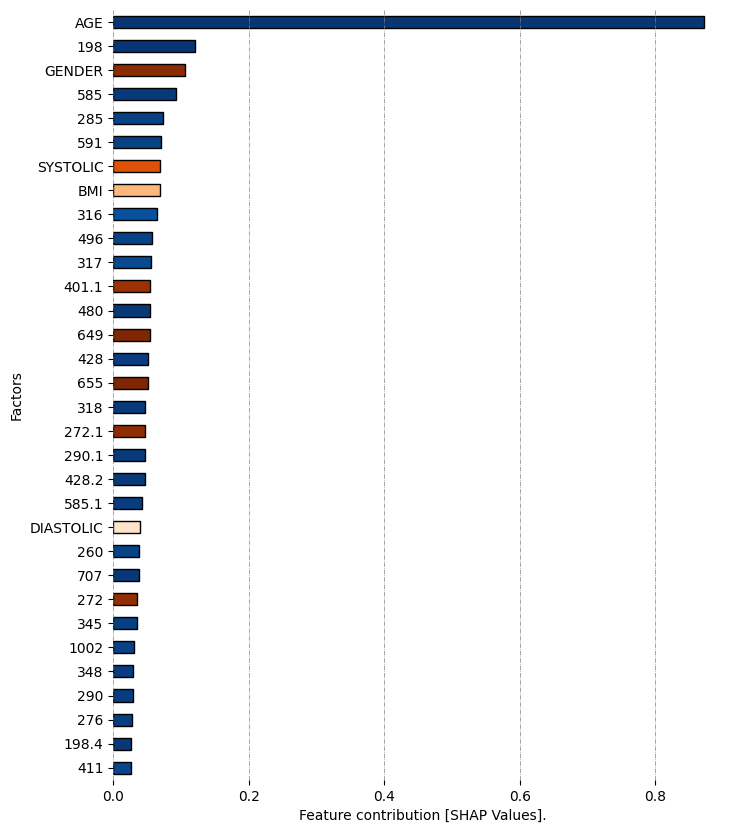

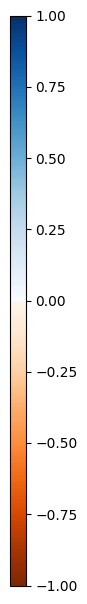

In [33]:
## feature importance plot

viridis = cm.get_cmap('viridis', 256)
top = cm.get_cmap('Oranges_r', 128)
bottom = cm.get_cmap('Blues', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)), bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

def ABS_SHAP(feature_importance_value, correlation_coeff_value, top, colors):

    correlation_coeff_value_ = {}
    for key, value in correlation_coeff_value.items():
        correlation_coeff_value_[key] = np.mean(value)
    corr_df = pd.DataFrame.from_dict(correlation_coeff_value_, orient='index').fillna(0)
    corr_df.reset_index(inplace=True)
    corr_df.columns  = ['Variable','Corr']
    color_assigned = []
    for corr in list(corr_df['Corr']):
        if not np.isnan(corr):
            color_assigned.append(colors[int((corr+1)/2 * len(colors))])
        else:
            color_assigned.append([1,1,1,1])
    corr_df['Sign'] = color_assigned

    feature_importance_value_ = {}
    feature_importance_value_std = {}
    for key, value in feature_importance_value.items():
        feature_importance_value_[key] = np.mean(value)
        feature_importance_value_std[key] = np.std(value)

    feature_importance_std_df = pd.DataFrame.from_dict(feature_importance_value_std, orient='index').fillna(0)
    feature_importance_std_df.reset_index(inplace=True)
    feature_importance_std_df.columns = ['Variable','SHAP_std']

    feature_importance_df = pd.DataFrame.from_dict(feature_importance_value_, orient='index').fillna(0)
    feature_importance_df.reset_index(inplace=True)
    feature_importance_df.columns = ['Variable','SHAP_abs']

    feature_importance_df = feature_importance_df.merge(feature_importance_std_df, left_on='Variable',right_on='Variable',how='inner')

    k2 = feature_importance_df.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = False).head(top).iloc[::-1]
    print(list(k2['Variable']))
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(8,10),legend=False, xerr='SHAP_std', edgecolor='black')
    ax.set_xlabel("Feature contribution [SHAP Values].")
    ax.set_ylabel("Factors")
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.xaxis.grid(color='gray', linestyle='-.', linewidth=0.5)
#     plt.savefig('feature_imp_0.png', dpi=300) 
#     plt.savefig('feature_imp_0.png', dpi=300, bbox_inches='tight')

    fig, aaxx = plt.subplots(figsize=(0.2, 15))
    fig.subplots_adjust(bottom=0.5)
    cmap = matplotlib.colors.ListedColormap(colors)
    norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
    cb1 = matplotlib.colorbar.ColorbarBase(aaxx, cmap=cmap,
                                norm=norm, orientation='vertical')
#     plt.savefig('feature_imp_1.png', dpi=300, bbox_inches='tight')
    
    return k2

ABS_SHAP(feature_importance_value, correlation_coeff_value, 32, newcolors) 

In [34]:
pd.read_csv('/u/student/2024/cs24btnsr11002/2.0/saved_dataset/original_testing_data.csv')

,WHITE,BLACK,ASIAN,HISPANIC,UN,OTHER,DIE_1y,GENDER,008,008.5,...,985,987,988,989,990,994,AGE,BMI,DIASTOLIC,SYSTOLIC
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,51.0,20.3,86.0,133.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,34.0,27.3,83.0,104.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,63.0,24.4,82.0,131.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,35.0,33.9,60.0,130.0
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,63.0,29.0,80.0,126.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63321,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,66.0,30.5,57.0,111.0
63322,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,21.0,26.6,77.0,108.0
63323,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,86.0,20.5,74.0,168.0
63324,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,62.0,34.0,76.0,124.0


In [35]:
## Train on synthetic dataset and test on real testing data set

random.seed(a=2021, version=2)

RECALL_THRESHOLD = 0.6  # hold this to compute other threshold related metrics
LABEL_INDEX = 6  # label column index in the dataset
RACE_COL = [0,1,2,3,4,5]
COL_LIST = list(real_data_df.columns)[len(RACE_COL)+1:]
CAT_IDX_wo_RACE_label = list(np.linspace(0, len(COL_LIST) - 5, num=len(COL_LIST) - 4).astype(int))
## load the dataset for model evaluation. Here it is real data. 30%
eval_real_data = pd.read_csv('/u/student/2024/cs24btnsr11002/2.0/saved_dataset/original_testing_data.csv').values.astype(np.float64)
eval_real_label = eval_real_data[:,LABEL_INDEX].astype(np.float64)
eval_real_data = np.delete(eval_real_data, RACE_COL + [LABEL_INDEX], axis=1)
print('\nThe number of records in evaluation (real) data is: %d' % len(eval_real_data))
print('The number of features in training (real) data is: %d' % len(eval_real_data[0]))
print('Positive vs Negative ratio in evaluation (real) data is: %f' % (np.sum(eval_real_label)/len(eval_real_label)))


pred_result = []
correlation_result = []

real_auroc_result = []
real_prauc_result = []
real_acc_result = []
real_ppv_result = []
real_npv_result = []
real_sens_result = []
real_spes_result = []

print('\n   !!!!!!!!!!!!!!!!!!! training is starting !!!!!!!!!!!!!!!!!!! ')

for run_ in range(len(model_id_list)):

    run = run_ + 1
    print('\n ######## Syn dataset %d ######## ' % run)
    syn_training_data = syn_data_list[run_]
    random.seed(a=2021, version=2)
    syn_training_data_index = np.linspace(0,len(syn_training_data)-1,len(syn_training_data)).astype('int')
    random.shuffle(syn_training_data_index)
    syn_training_data = syn_training_data[syn_training_data_index]
    syn_training_data_label = syn_training_data[:,LABEL_INDEX].astype(np.float64)
    syn_training_data = np.delete(syn_training_data, [LABEL_INDEX]+RACE_COL, axis = 1)
    
    gkf = KFold(n_splits=5, shuffle=True, random_state=0).split(X=syn_training_data, y=syn_training_data_label)

    param_grid = {
            'n_estimators': [500],
            'colsample_bytree': [0.9],
            'max_depth': [15],
            'num_leaves': [50],
            'reg_alpha': [1.3],
            'min_split_gain': [0.3],
            'subsample': [0.9],
            'subsample_freq': [40]
            }

    lgb_estimator = lgb.LGBMClassifier(boosting_type='gbdt',  objective='binary', num_boost_round=2000, learning_rate=0.01, metric='auc',categorical_feature=CAT_IDX_wo_RACE_label, n_jobs = 20)
    gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid, cv=gkf)
    gbm = gsearch.fit(X=syn_training_data, y=syn_training_data_label)
    print("Best parameters:\n")
    print(gbm.best_params_)

    y_scores = gbm.predict_proba(eval_real_data)
    y_scores = y_scores[:,1]
    tstr_auroc = roc_auc_score(y_score=y_scores, y_true=eval_real_label)
    tstr_prauc = average_precision_score(eval_real_label, y_scores)
    fpr, tpr, threshold_candidate = roc_curve(eval_real_label, y_scores)
    thres_index = (tpr > RECALL_THRESHOLD).tolist().index(True)
    thres = threshold_candidate[thres_index]
    print("Threshold for fixing recall as %.2f is %.4f" % (RECALL_THRESHOLD, thres))
    pred_y = np.array([(value>=thres)*1.0 for value in y_scores])

    tn, fp, fn, tp = confusion_matrix(eval_real_label, pred_y).ravel()
    tstr_ppv = tp / (tp + fp)
    tstr_npv = tn / (tn + fn)
    tstr_sens = tp / (tp + fn)
    tstr_spes = tn / (tn + fp)
    tstr_acc = (tn + tp) / (tn + fp + fn + tp)
    print("      *** Test on real data AUROC: %.4f, PRAUC: %.4f, ACC: %.4f, PPV: %.4f, NPV: %.4f, Sensitivity: %.4f, Specificity: %.4f" % (
    tstr_auroc, tstr_prauc, tstr_acc, tstr_ppv, tstr_npv, tstr_sens, tstr_spes))

    real_auroc_result.append(tstr_auroc)
    real_prauc_result.append(tstr_prauc)
    real_acc_result.append(tstr_acc)
    real_ppv_result.append(tstr_ppv)
    real_npv_result.append(tstr_npv)
    real_sens_result.append(tstr_sens)
    real_spes_result.append(tstr_spes)

    explainer = shap.TreeExplainer(gbm.best_estimator_)
#         shap_value_list.extend(explainer.shap_values(eval_real_data)[1])
    shap_df = pd.DataFrame(shap_values, columns=COL_LIST)
    shap_df_abs = abs(shap_df)

    feature_importance_mean = shap_df_abs.mean(axis=0).sort_values(ascending=False)
    feature_importance_value = {}
    for key, value in feature_importance_mean.items():
        if key in feature_importance_value.keys():
            feature_importance_value[key].append(value)
        else:
            feature_importance_value[key] = [value]
            
    np.save(f'./result/TSTR_feature_importance_run_{run}.npy', feature_importance_value)


print('TSTR AUROC: ', real_auroc_result)
utility_score['TSTR_auroc'] = real_auroc_result
        



The number of records in evaluation (real) data is: 63326
The number of features in training (real) data is: 1491
Positive vs Negative ratio in evaluation (real) data is: 0.116429

   !!!!!!!!!!!!!!!!!!! training is starting !!!!!!!!!!!!!!!!!!! 

 ######## Syn dataset 1 ######## 


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 11388, number of negative: 89829
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3432
[LightGBM] [Info] Number of data points in the train set: 101217, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.112511 -> initscore=-2.065348
[LightGBM] [Info] Start training from score -2.065348
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 11379, number of negative: 89838
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055388 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3429
[LightGBM] [Info] Number of data points in the train set: 101217, number of used features: 1049
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.112422 -> initscore=-2.066238
[LightGBM] [Info] Start training from score -2.066238
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 11426, number of negative: 89792
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3439
[LightGBM] [Info] Number of data points in the train set: 101218, number of used features: 1053
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.112885 -> initscore=-2.061604
[LightGBM] [Info] Start training from score -2.061604
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 11375, number of negative: 89843
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.119658 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3416
[LightGBM] [Info] Number of data points in the train set: 101218, number of used features: 1043
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.112381 -> initscore=-2.066646
[LightGBM] [Info] Start training from score -2.066646


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 11404, number of negative: 89814
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056776 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3432
[LightGBM] [Info] Number of data points in the train set: 101218, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.112668 -> initscore=-2.063777
[LightGBM] [Info] Start training from score -2.063777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14243, number of negative: 112279
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.113916 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3477
[LightGBM] [Info] Number of data points in the train set: 126522, number of used features: 1073
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.112573 -> initscore=-2.064721
[LightGBM] [Info] Start training from score -2.064721
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best parameters:

{'colsample_bytree': 0.9, 'max_depth': 15, 'min_split_gain': 0.3, 'n_esti

/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Threshold for fixing recall as 0.60 is 0.2702
      *** Test on real data AUROC: 0.8947, PRAUC: 0.5620, ACC: 0.8921, PPV: 0.5325, NPV: 0.9464, Sensitivity: 0.6000, Specificity: 0.9306
TSTR AUROC:  [np.float64(0.894741112680723)]


In [92]:
feature_importance_value

{'AGE': [0.8710124563171608],
 '198': [0.12126192973273962],
 'GENDER': [0.10594715099403013],
 '585': [0.09269619292046398],
 '285': [0.07338286761985967],
 '591': [0.07068514883446178],
 'SYSTOLIC': [0.06947070284633448],
 'BMI': [0.06886129300766886],
 '316': [0.06434350136040932],
 '496': [0.0567068227696893],
 '317': [0.05564328296740504],
 '401.1': [0.0549014440109913],
 '480': [0.054828358918468025],
 '649': [0.05369880530102365],
 '428': [0.051634102430494676],
 '655': [0.05156763380226775],
 '318': [0.046988933842914415],
 '272.1': [0.04695218988136819],
 '290.1': [0.046701917896518313],
 '428.2': [0.04647152955839376],
 '585.1': [0.0424954132720294],
 'DIASTOLIC': [0.03986461623268187],
 '260': [0.03880172472628642],
 '707': [0.038442346463342277],
 '272': [0.03467530228198186],
 '345': [0.034573962514618355],
 '1002': [0.03031064078182797],
 '348': [0.02971921063212695],
 '290': [0.028541538015986745],
 '276': [0.02826840768747166],
 '198.4': [0.026069025605379468],
 '411': 

## 1.g TRTS

In [36]:
## Train on real testing dataset and test on real training data set

random.seed(a=2021, version=2)

RECALL_THRESHOLD = 0.6  # hold this to compute other threshold related metrics
LABEL_INDEX = 6  # label column index in the dataset
RACE_COL = [0,1,2,3,4,5]
COL_LIST = list(real_data_df.columns)[len(RACE_COL)+1:]
CAT_IDX_wo_RACE_label = list(np.linspace(0, len(COL_LIST) - 5, num=len(COL_LIST) - 4).astype(int))

## Load the dataset for model training. Here it is real data. 70%
train_real_data = pd.read_csv('/u/student/2024/cs24btnsr11002/2.0/saved_dataset/original_testing_data.csv').values.astype(np.float64)
train_real_data_index = np.linspace(0,len(train_real_data)-1,len(train_real_data)).astype('int')
random.shuffle(train_real_data_index)
train_real_data = train_real_data[train_real_data_index]
train_real_label = train_real_data[:,LABEL_INDEX].astype(np.float64)
train_real_data = np.delete(train_real_data, [LABEL_INDEX]+RACE_COL, axis = 1)
print('The number of records in training (real) data is:  %d' % len(train_real_data))
print('The number of features in training (real) data is:  %d' % len(train_real_data[0]))
print('Positive vs Negative ratio in training (real) data is: %f' % (np.sum(train_real_label)/len(train_real_label)))

## load the dataset for model evaluation. Here it is real data. 30%
eval_real_data = pd.read_csv('/u/student/2024/cs24btnsr11002/2.0/saved_dataset/original_training_data.csv').values.astype(np.float64)
eval_real_label = eval_real_data[:,LABEL_INDEX].astype(np.float64)
eval_real_data = np.delete(eval_real_data, [LABEL_INDEX]+RACE_COL, axis=1)
print('\nThe number of records in evaluation (real) data is: %d' % len(eval_real_data))
print('The number of features in training (real) data is: %d' % len(eval_real_data[0]))
print('Positive vs Negative ratio in evaluation (real) data is: %f' % (np.sum(eval_real_label)/len(eval_real_label)))

## model training
print('\n !!!!!!!!!!!!!!!!!!! training is starting !!!!!!!!!!!!!!!!!!! ')

gkf = KFold(n_splits=5, shuffle=True, random_state=0).split(X=train_real_data, y=train_real_label)


# ############
# # try some candidates here

# param_grid = {
#     'n_estimators': [500, 1000],
#     'colsample_bytree': [0.7, 0.8],
#     'max_depth': [15, 25],
#     'num_leaves': [20, 50],
#     'reg_alpha': [1.1, 1.3],
# #     'reg_lambda': [1.1, 1.3],
#     'min_split_gain': [0.3, 0.5],
#     'subsample': [0.8, 0.9],
#     'subsample_freq': [20]
#     }
############

param_grid = {
            'n_estimators': [500],
            'colsample_bytree': [0.9],
            'max_depth': [15],
            'num_leaves': [50],
            'reg_alpha': [1.3],
            'min_split_gain': [0.3],
            'subsample': [0.9],
            'subsample_freq': [40]
            }

lgb_estimator = lgb.LGBMClassifier(boosting_type='gbdt',  objective='binary', num_boost_round=2000, learning_rate=0.01, metric='auc',categorical_feature=CAT_IDX_wo_RACE_label, n_jobs = 20)
gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid, cv=gkf)
gbm = gsearch.fit(X=train_real_data, y=train_real_label)
print("Best parameters:\n")
print(gbm.best_params_)

y_scores = gbm.predict_proba(eval_real_data)
y_scores = y_scores[:,1]
trtr_auroc = roc_auc_score(y_score=y_scores, y_true=eval_real_label)
trtr_prauc = average_precision_score(eval_real_label, y_scores)
fpr, tpr, threshold_candidate = roc_curve(eval_real_label, y_scores)
thres_index = (tpr > RECALL_THRESHOLD).tolist().index(True)
thres = threshold_candidate[thres_index]
print("Threshold for fixing recall as %.2f is %.4f" % (RECALL_THRESHOLD, thres))
pred_y = np.array([(value>=thres)*1.0 for value in y_scores])

tn, fp, fn, tp = confusion_matrix(eval_real_label, pred_y).ravel()
trtr_ppv = tp / (tp + fp)
trtr_npv = tn / (tn + fn)
trtr_sens = tp / (tp + fn)
trtr_spes = tn / (tn + fp)
trtr_acc = (tn + tp) / (tn + fp + fn + tp)
print("      *** Test on real data AUROC: %.4f, PRAUC: %.4f, ACC: %.4f, PPV: %.4f, NPV: %.4f, Sensitivity: %.4f, Specificity: %.4f" % (
trtr_auroc, trtr_prauc, trtr_acc, trtr_ppv, trtr_npv, trtr_sens, trtr_spes))

explainer = shap.TreeExplainer(gbm.best_estimator_)
shap_df = pd.DataFrame(shap_values, columns=COL_LIST)
shap_df_abs = abs(shap_df)

feature_importance_mean = shap_df_abs.mean(axis=0).sort_values(ascending=False)
feature_importance_value = {}
for key, value in feature_importance_mean.items():
    if key in feature_importance_value.keys():
        feature_importance_value[key].append(value)
    else:
        feature_importance_value[key] = [value]
        
subset_eval_data = eval_real_data[:shap_df.shape[0], :]  # Get matching rows
correlation_coeff_value = {}
for key in COL_LIST:
    feature_idx = COL_LIST.index(key)
    corr_value = np.corrcoef(shap_df[key], subset_eval_data[:, feature_idx])[1][0]
    if key in correlation_coeff_value:
        correlation_coeff_value[key].append(corr_value)
    else:
        correlation_coeff_value[key] = [corr_value]

# np.save('./result/r_70_train_r_30_test_correl_coeff_value.npy', correlation_coeff_value)
# shap_df.to_csv('./result/r_70_train_r_30_test_feature_importance.csv')
# np.save('./result/r_70_train_r_30_test_y_estimate.npy', y_scores)
# np.save('./result/r_70_train_r_30_test_y_label.npy', eval_real_label)
# joblib.dump(gbm.best_estimator_, './result/r_70_train_r_30_test.pkl')

print('TRTR AUROC: %.4f' % trtr_auroc)
print('TRTR AUPRC: %.4f' % trtr_prauc)
print('TRTR ACCURACY: %.4f' % trtr_acc)
print('TRTR PPV: %.4f' % trtr_ppv)
print('TRTR NPV: %.4f' % trtr_npv)
print('TRTR RECALL: %.4f' % trtr_sens)
print('TRTR SPESIFICITY: %.4f' % trtr_spes)




The number of records in training (real) data is:  63326
The number of features in training (real) data is:  1491
Positive vs Negative ratio in training (real) data is: 0.116429

The number of records in evaluation (real) data is: 147760
The number of features in training (real) data is: 1491
Positive vs Negative ratio in evaluation (real) data is: 0.119383

 !!!!!!!!!!!!!!!!!!! training is starting !!!!!!!!!!!!!!!!!!! 


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 5931, number of negative: 44729
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3208
[LightGBM] [Info] Number of data points in the train set: 50660, number of used features: 1164
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.117075 -> initscore=-2.020429
[LightGBM] [Info] Start training from score -2.020429
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 5885, number of negative: 44776
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094989 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3201
[LightGBM] [Info] Number of data points in the train set: 50661, number of used features: 1164
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116164 -> initscore=-2.029266
[LightGBM] [Info] Start training from score -2.029266
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 5870, number of negative: 44791
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3206
[LightGBM] [Info] Number of data points in the train set: 50661, number of used features: 1165
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.115868 -> initscore=-2.032153
[LightGBM] [Info] Start training from score -2.032153
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 5872, number of negative: 44789
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3188
[LightGBM] [Info] Number of data points in the train set: 50661, number of used features: 1155
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.115908 -> initscore=-2.031767
[LightGBM] [Info] Start training from score -2.031767
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 5934, number of negative: 44727
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3214
[LightGBM] [Info] Number of data points in the train set: 50661, number of used features: 1167
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.117132 -> initscore=-2.019879
[LightGBM] [Info] Start training from score -2.019879
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 7373, number of negative: 55953
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048843 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3296
[LightGBM] [Info] Number of data points in the train set: 63326, number of used features: 1207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116429 -> initscore=-2.026687
[LightGBM] [Info] Start training from score -2.026687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Threshold for fixing recall as 0.60 is 0.3490
      *** Test on real data AUROC: 0.9159, PRAUC: 0.6225, ACC: 0.9031, PPV: 0.5931, NPV: 0.9457, Sensitivity: 0.6001, Specificity: 0.9442


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


TRTR AUROC: 0.9159
TRTR AUPRC: 0.6225
TRTR ACCURACY: 0.9031
TRTR PPV: 0.5931
TRTR NPV: 0.9457
TRTR RECALL: 0.6001
TRTR SPESIFICITY: 0.9442


In [37]:
## Train on real testing dataset and test on synthetic training data set

random.seed(a=2021, version=2)

train_real_data = pd.read_csv('/u/student/2024/cs24btnsr11002/2.0/saved_dataset/original_testing_data.csv').values.astype(np.float64)
train_real_data_index = np.linspace(0,len(train_real_data)-1,len(train_real_data)).astype('int')
random.shuffle(train_real_data_index)
train_real_data = train_real_data[train_real_data_index]
train_real_label = train_real_data[:,LABEL_INDEX].astype(np.float64)
train_real_data = np.delete(train_real_data, [LABEL_INDEX]+RACE_COL, axis = 1)
print('The number of records in training (real) data is:  %d' % len(train_real_data))
print('The number of features in training (real) data is:  %d' % len(train_real_data[0]))
print('Positive vs Negative ratio in training (real) data is: %f' % (np.sum(train_real_label)/len(train_real_label)))

gkf = KFold(n_splits=5, shuffle=True, random_state=0).split(X=train_real_data, y=train_real_label)

param_grid = {
            'n_estimators': [500],
            'colsample_bytree': [0.9],
            'max_depth': [15],
            'num_leaves': [50],
            'reg_alpha': [1.3],
            'min_split_gain': [0.3],
            'subsample': [0.9],
            'subsample_freq': [40]
            }

lgb_estimator = lgb.LGBMClassifier(boosting_type='gbdt',  objective='binary', num_boost_round=2000, learning_rate=0.01, metric='auc',categorical_feature=CAT_IDX_wo_RACE_label, n_jobs = 20)

gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid, cv=gkf)
gbm = gsearch.fit(X=train_real_data, y=train_real_label)
print("Best parameters:\n")
print(gbm.best_params_)

print('\n   !!!!!!!!!!!!!!!!!!! evaluation is starting !!!!!!!!!!!!!!!!!!! ')

syn_auroc_result = []
syn_prauc_result = []
syn_acc_result = []
syn_ppv_result = []
syn_npv_result = []
syn_sens_result = []
syn_spes_result = []

for run_ in range(len(model_id_list)):

    run = run_ + 1
    print('\n ######## Syn dataset %d ######## ' % run)
    
    syn_data = syn_data_list[run_]
    random.seed(a=2021, version=2)
    syn_data_index = np.linspace(0,len(syn_data)-1,len(syn_data)).astype('int')
    random.shuffle(syn_data_index)
    syn_data = syn_data[syn_data_index]
    syn_label = syn_data[:,LABEL_INDEX].astype(np.float64)
    syn_data = np.delete(syn_data, [LABEL_INDEX]+RACE_COL, axis = 1)

    y_scores = gbm.best_estimator_.predict_proba(syn_data)
    y_scores = y_scores[:,1]
    auroc = roc_auc_score(y_score=y_scores, y_true=syn_label)
    prauc = average_precision_score(syn_label, y_scores)
    fpr, tpr, threshold_candidate = roc_curve(syn_label, y_scores)
    thres_index = (tpr > RECALL_THRESHOLD).tolist().index(True)
    thres = threshold_candidate[thres_index]
    print("Threshold for fixing recall as %.2f is %.4f" % (RECALL_THRESHOLD, thres))
    pred_y = np.array([(value>=thres)*1.0 for value in y_scores])

    tn, fp, fn, tp = confusion_matrix(syn_label, pred_y).ravel()
    ppv = tp / (tp + fp)
    npv = tn / (tn + fn)
    sens = tp / (tp + fn)
    spes = tn / (tn + fp)
    acc = (tn + tp) / (tn + fp + fn + tp)
    print("      *** Test on syn data AUROC: %.4f, PRAUC: %.4f, ACC: %.4f, PPV: %.4f, NPV: %.4f, Sensitivity: %.4f, Specificity: %.4f" % (
    auroc, prauc, acc, ppv, npv, sens, spes))   

    syn_auroc_result.append(auroc)
    syn_prauc_result.append(prauc)
    syn_acc_result.append(acc)
    syn_ppv_result.append(ppv)
    syn_npv_result.append(npv)
    syn_sens_result.append(sens)
    syn_spes_result.append(spes)


print('TRTS AUROC: ', syn_auroc_result)
utility_score['TRTS_auroc'] = syn_auroc_result
    

The number of records in training (real) data is:  63326
The number of features in training (real) data is:  1491
Positive vs Negative ratio in training (real) data is: 0.116429


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 5931, number of negative: 44729
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051591 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3208
[LightGBM] [Info] Number of data points in the train set: 50660, number of used features: 1164
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.117075 -> initscore=-2.020429
[LightGBM] [Info] Start training from score -2.020429
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 5885, number of negative: 44776
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036007 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3201
[LightGBM] [Info] Number of data points in the train set: 50661, number of used features: 1164
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116164 -> initscore=-2.029266
[LightGBM] [Info] Start training from score -2.029266
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 5870, number of negative: 44791
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3206
[LightGBM] [Info] Number of data points in the train set: 50661, number of used features: 1165
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.115868 -> initscore=-2.032153
[LightGBM] [Info] Start training from score -2.032153
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 5872, number of negative: 44789
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065709 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3188
[LightGBM] [Info] Number of data points in the train set: 50661, number of used features: 1155
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.115908 -> initscore=-2.031767
[LightGBM] [Info] Start training from score -2.031767
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 5934, number of negative: 44727
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039564 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3214
[LightGBM] [Info] Number of data points in the train set: 50661, number of used features: 1167
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.117132 -> initscore=-2.019879
[LightGBM] [Info] Start training from score -2.019879
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 7373, number of negative: 55953
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3296
[LightGBM] [Info] Number of data points in the train set: 63326, number of used features: 1207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116429 -> initscore=-2.026687
[LightGBM] [Info] Start training from score -2.026687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Threshold for fixing recall as 0.60 is 0.2755
      *** Test on syn data AUROC: 0.8816, PRAUC: 0.5239, ACC: 0.8737, PPV: 0.4540, NPV: 0.9471, Sensitivity: 0.6000, Specificity: 0.9085
TRTS AUROC:  [np.float64(0.8815851668418317)]


## 1.h feature importance

In [38]:
# Load the real dataset for model training.

random.seed(a=2021, version=2)

RECALL_THRESHOLD = 0.6  # hold this to compute other threshold related metrics
LABEL_INDEX = 6  # label column index in the dataset
RACE_COL = [0,1,2,3,4,5]
# CAT_IDX_wo_RACE_label = list(np.linspace(0, len(COL_LIST) - 5, num=len(COL_LIST) - 4).astype(int))


feature_importance_TRTR = np.load('./result/feature_importance_TRTR.npy', allow_pickle=True).item()
COL_LIST = list(real_data_df.columns)[len(RACE_COL)+1:]
top_feature_indices = [COL_LIST.index(name) for name in list(feature_importance_TRTR.keys())]
cat_or_not = [0,1,1,1,1,0,0] + [1]*18 + [0] + [1]*(len(COL_LIST)-26) # indicate mannually the binary features

train_real_data = pd.read_csv('/u/student/2024/cs24btnsr11002/2.0/saved_dataset/original_training_data.csv').values.astype(np.float64)
train_real_data_index = np.linspace(0,len(train_real_data)-1,len(train_real_data)).astype('int')
random.shuffle(train_real_data_index)
train_real_data = train_real_data[train_real_data_index]
train_real_label = train_real_data[:,LABEL_INDEX].astype(np.float64)
train_real_data = np.delete(train_real_data, [LABEL_INDEX]+RACE_COL, axis = 1)
print('The number of records in training (real) data is:  %d' % len(train_real_data))
print('The number of features in training (real) data is:  %d' % len(train_real_data[0]))
print('Positive vs Negative ratio in training (real) data is: %f' % (np.sum(train_real_label)/len(train_real_label)))

## load the dataset for model evaluation. Here it is real data. 30%
eval_real_data = pd.read_csv('/u/student/2024/cs24btnsr11002/2.0/saved_dataset/original_testing_data.csv').values.astype(np.float64)
eval_real_label = eval_real_data[:,LABEL_INDEX].astype(np.float64)
eval_real_data = np.delete(eval_real_data, [LABEL_INDEX]+RACE_COL, axis=1)
print('\nThe number of records in evaluation (real) data is: %d' % len(eval_real_data))
print('The number of features in training (real) data is: %d' % len(eval_real_data[0]))
print('Positive vs Negative ratio in evaluation (real) data is: %f' % (np.sum(eval_real_label)/len(eval_real_label)))

## model training
print('\n !!!!!!!!!!!!!!!!!!! training is starting !!!!!!!!!!!!!!!!!!! ')

test_candidates = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
auroc_performance = {}
auprc_performance = {}

for num_features in test_candidates:
    print('Testing top %d features: ' % num_features)

    selected_feature_indices = top_feature_indices[:num_features]
    selected_feature_cat_or_not = cat_or_not[:num_features]
    cat_indices = [i for i in range(len(selected_feature_cat_or_not)) if selected_feature_cat_or_not[i] == 1]
    
    gkf = KFold(n_splits=5, shuffle=True, random_state=0).split(X=train_real_data, y=train_real_label)

    param_grid = {
            'n_estimators': [500],
            'colsample_bytree': [0.9],
            'max_depth': [15],
            'num_leaves': [50],
            'reg_alpha': [1.3],
            'min_split_gain': [0.3],
            'subsample': [0.9],
            'subsample_freq': [40]
            }

    lgb_estimator = lgb.LGBMClassifier(boosting_type='gbdt',  objective='binary', num_boost_round=2000, learning_rate=0.01, metric='auc',categorical_feature=cat_indices, n_jobs = 20)

    gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid, cv=gkf)
    gbm = gsearch.fit(X=train_real_data[:, selected_feature_indices], y=train_real_label)
    print("Best parameters:\n")
    print(gbm.best_params_)

    y_scores = gbm.predict_proba(eval_real_data[:, selected_feature_indices])
    y_scores = y_scores[:,1]
    auroc = roc_auc_score(y_score=y_scores, y_true=eval_real_label)
    prauc = average_precision_score(eval_real_label, y_scores)
    fpr, tpr, threshold_candidate = roc_curve(eval_real_label, y_scores)
    thres_index = (tpr > RECALL_THRESHOLD).tolist().index(True)
    thres = threshold_candidate[thres_index]
    print("      Threshold for fixing recall as %.2f is %.4f" % (RECALL_THRESHOLD, thres))
    pred_y = np.array([(value>=thres)*1.0 for value in y_scores])

    tn, fp, fn, tp = confusion_matrix(eval_real_label, pred_y).ravel()
    ppv = tp / (tp + fp)
    npv = tn / (tn + fn)
    sens = tp / (tp + fn)
    spes = tn / (tn + fp)
    acc = (tn + tp) / (tn + fp + fn + tp)
    print("      *** Test on real data AUROC: %.4f, PRAUC: %.4f, ACC: %.4f, PPV: %.4f, NPV: %.4f, Sensitivity: %.4f, Specificity: %.4f" % (
    auroc, prauc, acc, ppv, npv, sens, spes))
    
    auroc_performance[num_features] = auroc
    auprc_performance[num_features] = prauc
    
np.save('./result/auroc_performance_feature_imp.npy', auroc_performance)
np.save('./result/auprc_performance_feature_imp.npy', auprc_performance)
    

The number of records in training (real) data is:  147760
The number of features in training (real) data is:  1491
Positive vs Negative ratio in training (real) data is: 0.119383

The number of records in evaluation (real) data is: 63326
The number of features in training (real) data is: 1491
Positive vs Negative ratio in evaluation (real) data is: 0.116429

 !!!!!!!!!!!!!!!!!!! training is starting !!!!!!!!!!!!!!!!!!! 
Testing top 5 features: 
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14114, number of negative: 104094
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 5
[Light

/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14114, number of negative: 104094
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119400 -> initscore=-1.998127
[LightGBM] [Info] Start training from score -1.998127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14117, number of negative: 104091
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002381 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119425 -> initscore=-1.997886
[LightGBM] [Info] Start training from score -1.997886
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14080, number of negative: 104128
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119112 -> initscore=-2.000866
[LightGBM] [Info] Start training from score -2.000866
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14135, number of negative: 104073
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001925 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119577 -> initscore=-1.996439
[LightGBM] [Info] Start training from score -1.996439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 17640, number of negative: 130120
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002619 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 147760, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119383 -> initscore=-1.998288
[LightGBM] [Info] Start training from score -1.998288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


      Threshold for fixing recall as 0.60 is 0.2204
      *** Test on real data AUROC: 0.8483, PRAUC: 0.4600, ACC: 0.8475, PPV: 0.3977, NPV: 0.9437, Sensitivity: 0.6019, Specificity: 0.8799
Testing top 10 features: 
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14114, number of negative: 104094
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 304
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119400 -> initscore=-1.998127
[LightGBM] [Info] Start training from score -1.998127


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14114, number of negative: 104094
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 303
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119400 -> initscore=-1.998127
[LightGBM] [Info] Start training from score -1.998127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14117, number of negative: 104091
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 304
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119425 -> initscore=-1.997886
[LightGBM] [Info] Start training from score -1.997886
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14080, number of negative: 104128
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 304
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119112 -> initscore=-2.000866
[LightGBM] [Info] Start training from score -2.000866
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14135, number of negative: 104073
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 304
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119577 -> initscore=-1.996439
[LightGBM] [Info] Start training from score -1.996439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 17640, number of negative: 130120
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003984 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 305
[LightGBM] [Info] Number of data points in the train set: 147760, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119383 -> initscore=-1.998288
[LightGBM] [Info] Start training from score -1.998288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


      Threshold for fixing recall as 0.60 is 0.2517
      *** Test on real data AUROC: 0.8612, PRAUC: 0.4833, ACC: 0.8613, PPV: 0.4313, NPV: 0.9444, Sensitivity: 0.6002, Specificity: 0.8957
Testing top 15 features: 
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14114, number of negative: 104094
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119400 -> initscore=-1.998127
[LightGBM] [Info] Start training from score -1.998127


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14114, number of negative: 104094
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119400 -> initscore=-1.998127
[LightGBM] [Info] Start training from score -1.998127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14117, number of negative: 104091
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119425 -> initscore=-1.997886
[LightGBM] [Info] Start training from score -1.997886
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14080, number of negative: 104128
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119112 -> initscore=-2.000866
[LightGBM] [Info] Start training from score -2.000866
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14135, number of negative: 104073
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119577 -> initscore=-1.996439
[LightGBM] [Info] Start training from score -1.996439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 17640, number of negative: 130120
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 147760, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119383 -> initscore=-1.998288
[LightGBM] [Info] Start training from score -1.998288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


      Threshold for fixing recall as 0.60 is 0.2603
      *** Test on real data AUROC: 0.8684, PRAUC: 0.4988, ACC: 0.8669, PPV: 0.4466, NPV: 0.9448, Sensitivity: 0.6000, Specificity: 0.9020
Testing top 20 features: 
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14114, number of negative: 104094
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004830 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 334
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119400 -> initscore=-1.998127
[LightGBM] [Info] Start training from score -1.998127


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14114, number of negative: 104094
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 333
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119400 -> initscore=-1.998127
[LightGBM] [Info] Start training from score -1.998127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14117, number of negative: 104091
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005004 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 334
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119425 -> initscore=-1.997886
[LightGBM] [Info] Start training from score -1.997886
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14080, number of negative: 104128
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 334
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119112 -> initscore=-2.000866
[LightGBM] [Info] Start training from score -2.000866
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14135, number of negative: 104073
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 334
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119577 -> initscore=-1.996439
[LightGBM] [Info] Start training from score -1.996439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 17640, number of negative: 130120
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 335
[LightGBM] [Info] Number of data points in the train set: 147760, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119383 -> initscore=-1.998288
[LightGBM] [Info] Start training from score -1.998288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


      Threshold for fixing recall as 0.60 is 0.2701
      *** Test on real data AUROC: 0.8732, PRAUC: 0.5069, ACC: 0.8714, PPV: 0.4600, NPV: 0.9451, Sensitivity: 0.6000, Specificity: 0.9072
Testing top 25 features: 
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14114, number of negative: 104094
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 453
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119400 -> initscore=-1.998127
[LightGBM] [Info] Start training from score -1.998127


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14114, number of negative: 104094
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005785 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 452
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119400 -> initscore=-1.998127
[LightGBM] [Info] Start training from score -1.998127


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14117, number of negative: 104091
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 452
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119425 -> initscore=-1.997886
[LightGBM] [Info] Start training from score -1.997886
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14080, number of negative: 104128
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005820 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 452
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119112 -> initscore=-2.000866
[LightGBM] [Info] Start training from score -2.000866
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14135, number of negative: 104073
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 451
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119577 -> initscore=-1.996439
[LightGBM] [Info] Start training from score -1.996439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 17640, number of negative: 130120
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007157 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 455
[LightGBM] [Info] Number of data points in the train set: 147760, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119383 -> initscore=-1.998288
[LightGBM] [Info] Start training from score -1.998288
Best parameters:

{'colsample_bytree': 0.9, 'max_depth': 15, 'min_split_gain': 0.3, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'subsample': 0.9, 'subsample_freq': 40}


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


      Threshold for fixing recall as 0.60 is 0.2791
      *** Test on real data AUROC: 0.8789, PRAUC: 0.5167, ACC: 0.8754, PPV: 0.4724, NPV: 0.9453, Sensitivity: 0.6000, Specificity: 0.9117
Testing top 30 features: 
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Info] Number of positive: 14114, number of negative: 104094
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.131154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 467
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119400 -> initscore=-1.998127
[LightGBM] [Info] Start training from score -1.998127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14114, number of negative: 104094
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005791 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 466
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119400 -> initscore=-1.998127
[LightGBM] [Info] Start training from score -1.998127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14117, number of negative: 104091
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 466
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119425 -> initscore=-1.997886
[LightGBM] [Info] Start training from score -1.997886
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14080, number of negative: 104128
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005768 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 466
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119112 -> initscore=-2.000866
[LightGBM] [Info] Start training from score -2.000866
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14135, number of negative: 104073
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 465
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119577 -> initscore=-1.996439
[LightGBM] [Info] Start training from score -1.996439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 17640, number of negative: 130120
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 469
[LightGBM] [Info] Number of data points in the train set: 147760, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119383 -> initscore=-1.998288
[LightGBM] [Info] Start training from score -1.998288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best parameters:

{'colsample_bytree': 0.9, 'max_depth': 15, 'min_split_gain': 0.3, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'subsample': 0.9, 'subsample_freq': 40}


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


      Threshold for fixing recall as 0.60 is 0.2967
      *** Test on real data AUROC: 0.8859, PRAUC: 0.5284, ACC: 0.8796, PPV: 0.4862, NPV: 0.9456, Sensitivity: 0.6000, Specificity: 0.9164
Testing top 35 features: 
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14114, number of negative: 104094
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005750 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 481
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119400 -> initscore=-1.998127
[LightGBM] [Info] Start training from score -1.998127


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14114, number of negative: 104094
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006145 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 480
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119400 -> initscore=-1.998127
[LightGBM] [Info] Start training from score -1.998127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14117, number of negative: 104091
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006720 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 480
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119425 -> initscore=-1.997886
[LightGBM] [Info] Start training from score -1.997886
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14080, number of negative: 104128
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 480
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119112 -> initscore=-2.000866
[LightGBM] [Info] Start training from score -2.000866
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14135, number of negative: 104073
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 479
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119577 -> initscore=-1.996439
[LightGBM] [Info] Start training from score -1.996439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 17640, number of negative: 130120
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 483
[LightGBM] [Info] Number of data points in the train set: 147760, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119383 -> initscore=-1.998288
[LightGBM] [Info] Start training from score -1.998288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best parameters:

{'colsample_bytree': 0.9, 'max_depth': 15, 'min_split_gain': 0.3, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'subsample': 0.9, 'subsample

/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


      Threshold for fixing recall as 0.60 is 0.3087
      *** Test on real data AUROC: 0.8924, PRAUC: 0.5529, ACC: 0.8857, PPV: 0.5077, NPV: 0.9460, Sensitivity: 0.6000, Specificity: 0.9233
Testing top 40 features: 
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14114, number of negative: 104094
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008897 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 495
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119400 -> initscore=-1.998127
[LightGBM] [Info] Start training from score -1.998127


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14114, number of negative: 104094
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 494
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119400 -> initscore=-1.998127
[LightGBM] [Info] Start training from score -1.998127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14117, number of negative: 104091
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007004 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 494
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119425 -> initscore=-1.997886
[LightGBM] [Info] Start training from score -1.997886
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14080, number of negative: 104128
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 494
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119112 -> initscore=-2.000866
[LightGBM] [Info] Start training from score -2.000866
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14135, number of negative: 104073
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 493
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119577 -> initscore=-1.996439
[LightGBM] [Info] Start training from score -1.996439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 17640, number of negative: 130120
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 497
[LightGBM] [Info] Number of data points in the train set: 147760, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119383 -> initscore=-1.998288
[LightGBM] [Info] Start training from score -1.998288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best parameters:

{'colsample_bytree': 0.9, 'max_depth': 15, 'min_split_gain': 0.3, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'subsample': 0.9, 'subsample

/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


      Threshold for fixing recall as 0.60 is 0.3165
      *** Test on real data AUROC: 0.8957, PRAUC: 0.5633, ACC: 0.8881, PPV: 0.5168, NPV: 0.9462, Sensitivity: 0.6002, Specificity: 0.9261
Testing top 45 features: 
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14114, number of negative: 104094
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007367 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 509
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119400 -> initscore=-1.998127
[LightGBM] [Info] Start training from score -1.998127


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14114, number of negative: 104094
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007931 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 508
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119400 -> initscore=-1.998127
[LightGBM] [Info] Start training from score -1.998127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14117, number of negative: 104091
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 508
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119425 -> initscore=-1.997886
[LightGBM] [Info] Start training from score -1.997886
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14080, number of negative: 104128
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 508
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119112 -> initscore=-2.000866
[LightGBM] [Info] Start training from score -2.000866
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14135, number of negative: 104073
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 507
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119577 -> initscore=-1.996439
[LightGBM] [Info] Start training from score -1.996439


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 17640, number of negative: 130120
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 511
[LightGBM] [Info] Number of data points in the train set: 147760, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119383 -> initscore=-1.998288
[LightGBM] [Info] Start training from score -1.998288
Best parameters:

{'colsample_bytree': 0.9, 'max_depth': 15, 'min_split_gain': 0.3, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'subsample': 0.9, 'subsample_freq': 40}


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


      Threshold for fixing recall as 0.60 is 0.3265
      *** Test on real data AUROC: 0.8993, PRAUC: 0.5720, ACC: 0.8915, PPV: 0.5299, NPV: 0.9464, Sensitivity: 0.6000, Specificity: 0.9299
Testing top 50 features: 
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14114, number of negative: 104094
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 524
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119400 -> initscore=-1.998127
[LightGBM] [Info] Start training from score -1.998127


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14114, number of negative: 104094
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 523
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119400 -> initscore=-1.998127
[LightGBM] [Info] Start training from score -1.998127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14117, number of negative: 104091
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 523
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119425 -> initscore=-1.997886
[LightGBM] [Info] Start training from score -1.997886
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14080, number of negative: 104128
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 523
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119112 -> initscore=-2.000866
[LightGBM] [Info] Start training from score -2.000866
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14135, number of negative: 104073
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 522
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119577 -> initscore=-1.996439
[LightGBM] [Info] Start training from score -1.996439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 17640, number of negative: 130120
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 526
[LightGBM] [Info] Number of data points in the train set: 147760, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119383 -> initscore=-1.998288
[LightGBM] [Info] Start training from score -1.998288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best parameters:

{'colsample_bytree': 0.9, 'max_depth': 15, 'min_split_gain': 0.3, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'subsample': 0.9, 'subsample_freq': 40}


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


      Threshold for fixing recall as 0.60 is 0.3291
      *** Test on real data AUROC: 0.9004, PRAUC: 0.5753, ACC: 0.8930, PPV: 0.5360, NPV: 0.9465, Sensitivity: 0.6000, Specificity: 0.9315
Testing top 55 features: 
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14114, number of negative: 104094


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 539
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119400 -> initscore=-1.998127
[LightGBM] [Info] Start training from score -1.998127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14114, number of negative: 104094
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 538
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119400 -> initscore=-1.998127
[LightGBM] [Info] Start training from score -1.998127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14117, number of negative: 104091
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 538
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119425 -> initscore=-1.997886
[LightGBM] [Info] Start training from score -1.997886
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14080, number of negative: 104128
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 538
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119112 -> initscore=-2.000866
[LightGBM] [Info] Start training from score -2.000866
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14135, number of negative: 104073
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 537
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119577 -> initscore=-1.996439
[LightGBM] [Info] Start training from score -1.996439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 17640, number of negative: 130120
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 541
[LightGBM] [Info] Number of data points in the train set: 147760, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119383 -> initscore=-1.998288
[LightGBM] [Info] Start training from score -1.998288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best parameters:

{'colsample_bytree': 0.9, 'max_depth': 15, 'min_split_gain': 0.3, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'subsample': 0.9, 'subsample_freq': 40}


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


      Threshold for fixing recall as 0.60 is 0.3315
      *** Test on real data AUROC: 0.9013, PRAUC: 0.5771, ACC: 0.8938, PPV: 0.5396, NPV: 0.9465, Sensitivity: 0.6000, Specificity: 0.9325
Testing top 60 features: 
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14114, number of negative: 104094


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 553
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119400 -> initscore=-1.998127
[LightGBM] [Info] Start training from score -1.998127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14114, number of negative: 104094
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 552
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119400 -> initscore=-1.998127
[LightGBM] [Info] Start training from score -1.998127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14117, number of negative: 104091
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 552
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119425 -> initscore=-1.997886
[LightGBM] [Info] Start training from score -1.997886
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14080, number of negative: 104128
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 552
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119112 -> initscore=-2.000866
[LightGBM] [Info] Start training from score -2.000866
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14135, number of negative: 104073
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 551
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119577 -> initscore=-1.996439
[LightGBM] [Info] Start training from score -1.996439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 17640, number of negative: 130120
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 555
[LightGBM] [Info] Number of data points in the train set: 147760, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119383 -> initscore=-1.998288
[LightGBM] [Info] Start training from score -1.998288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best parameters:

{'colsample_bytree': 0.9, 'max_depth': 15, 'min_split_gain': 0.3, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'subsample': 0.9, 'subsample_freq': 40}


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


      Threshold for fixing recall as 0.60 is 0.3315
      *** Test on real data AUROC: 0.9020, PRAUC: 0.5795, ACC: 0.8938, PPV: 0.5393, NPV: 0.9465, Sensitivity: 0.6000, Specificity: 0.9325
Testing top 65 features: 
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Info] Number of positive: 14114, number of negative: 104094
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 567
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119400 -> initscore=-1.998127
[LightGBM] [Info] Start training from score -1.998127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14114, number of negative: 104094
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 566
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119400 -> initscore=-1.998127
[LightGBM] [Info] Start training from score -1.998127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14117, number of negative: 104091
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 566
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119425 -> initscore=-1.997886
[LightGBM] [Info] Start training from score -1.997886
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14080, number of negative: 104128
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 566
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119112 -> initscore=-2.000866
[LightGBM] [Info] Start training from score -2.000866


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14135, number of negative: 104073
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 565
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119577 -> initscore=-1.996439
[LightGBM] [Info] Start training from score -1.996439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 17640, number of negative: 130120
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 569
[LightGBM] [Info] Number of data points in the train set: 147760, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119383 -> initscore=-1.998288
[LightGBM] [Info] Start training from score -1.998288
Best parameters:

{'colsample_bytree': 0.9, 'max_depth': 15, 'min_split_gain': 0.3, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'subsample': 0.9, 'subsample_freq': 40}


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


      Threshold for fixing recall as 0.60 is 0.3383
      *** Test on real data AUROC: 0.9045, PRAUC: 0.5866, ACC: 0.8962, PPV: 0.5496, NPV: 0.9467, Sensitivity: 0.6000, Specificity: 0.9352
Testing top 70 features: 
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Info] Number of positive: 14114, number of negative: 104094
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 582
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119400 -> initscore=-1.998127
[LightGBM] [Info] Start training from score -1.998127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14114, number of negative: 104094
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 581
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119400 -> initscore=-1.998127
[LightGBM] [Info] Start training from score -1.998127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14117, number of negative: 104091
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 581
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119425 -> initscore=-1.997886
[LightGBM] [Info] Start training from score -1.997886
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14080, number of negative: 104128
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 581
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119112 -> initscore=-2.000866
[LightGBM] [Info] Start training from score -2.000866
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14135, number of negative: 104073
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 580
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119577 -> initscore=-1.996439
[LightGBM] [Info] Start training from score -1.996439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 17640, number of negative: 130120
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 584
[LightGBM] [Info] Number of data points in the train set: 147760, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119383 -> initscore=-1.998288
[LightGBM] [Info] Start training from score -1.998288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best parameters:

{'colsample_bytree': 0.9, 'max_depth': 15, 'min_split_gain': 0.3, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'subsample': 0.9, 'subsample_freq': 40}


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


      Threshold for fixing recall as 0.60 is 0.3427
      *** Test on real data AUROC: 0.9057, PRAUC: 0.5883, ACC: 0.8973, PPV: 0.5544, NPV: 0.9467, Sensitivity: 0.6000, Specificity: 0.9364
Testing top 75 features: 
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Info] Number of positive: 14114, number of negative: 104094
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 595
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119400 -> initscore=-1.998127
[LightGBM] [Info] Start training from score -1.998127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14114, number of negative: 104094
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 594
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119400 -> initscore=-1.998127
[LightGBM] [Info] Start training from score -1.998127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14117, number of negative: 104091
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 594
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119425 -> initscore=-1.997886
[LightGBM] [Info] Start training from score -1.997886
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14080, number of negative: 104128
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 594
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119112 -> initscore=-2.000866
[LightGBM] [Info] Start training from score -2.000866


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14135, number of negative: 104073
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008958 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 593
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119577 -> initscore=-1.996439
[LightGBM] [Info] Start training from score -1.996439


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 17640, number of negative: 130120
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 597
[LightGBM] [Info] Number of data points in the train set: 147760, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119383 -> initscore=-1.998288
[LightGBM] [Info] Start training from score -1.998288
Best parameters:

{'colsample_bytree': 0.9, 'max_depth': 15, 'min_split_gain': 0.3, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'subsample': 0.9, 'subsample_freq': 40}


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


      Threshold for fixing recall as 0.60 is 0.3446
      *** Test on real data AUROC: 0.9070, PRAUC: 0.5913, ACC: 0.8976, PPV: 0.5560, NPV: 0.9467, Sensitivity: 0.6000, Specificity: 0.9369
Testing top 80 features: 
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Info] Number of positive: 14114, number of negative: 104094
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 609
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119400 -> initscore=-1.998127
[LightGBM] [Info] Start training from score -1.998127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14114, number of negative: 104094
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 608
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119400 -> initscore=-1.998127
[LightGBM] [Info] Start training from score -1.998127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14117, number of negative: 104091
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 608
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119425 -> initscore=-1.997886
[LightGBM] [Info] Start training from score -1.997886
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14080, number of negative: 104128
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 608
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119112 -> initscore=-2.000866
[LightGBM] [Info] Start training from score -2.000866
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14135, number of negative: 104073
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008812 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 607
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119577 -> initscore=-1.996439
[LightGBM] [Info] Start training from score -1.996439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 17640, number of negative: 130120
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011701 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 611
[LightGBM] [Info] Number of data points in the train set: 147760, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119383 -> initscore=-1.998288
[LightGBM] [Info] Start training from score -1.998288
Best parameters:

{'colsample_bytree': 0.9, 'max_depth': 15, 'min_split_gain': 0.3, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'subsample': 0.9, 'subsample_freq': 40}


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


      Threshold for fixing recall as 0.60 is 0.3470
      *** Test on real data AUROC: 0.9078, PRAUC: 0.5951, ACC: 0.8978, PPV: 0.5566, NPV: 0.9468, Sensitivity: 0.6004, Specificity: 0.9370
Testing top 85 features: 
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Info] Number of positive: 14114, number of negative: 104094
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 622
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 85
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119400 -> initscore=-1.998127
[LightGBM] [Info] Start training from score -1.998127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14114, number of negative: 104094
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 621
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 85
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119400 -> initscore=-1.998127
[LightGBM] [Info] Start training from score -1.998127


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14117, number of negative: 104091
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 621
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 85
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119425 -> initscore=-1.997886
[LightGBM] [Info] Start training from score -1.997886


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14080, number of negative: 104128
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 621
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 85
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119112 -> initscore=-2.000866
[LightGBM] [Info] Start training from score -2.000866


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14135, number of negative: 104073
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 620
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 85
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119577 -> initscore=-1.996439
[LightGBM] [Info] Start training from score -1.996439


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 17640, number of negative: 130120
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 624
[LightGBM] [Info] Number of data points in the train set: 147760, number of used features: 85
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119383 -> initscore=-1.998288
[LightGBM] [Info] Start training from score -1.998288
Best parameters:

{'colsample_bytree': 0.9, 'max_depth': 15, 'min_split_gain': 0.3, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'subsample': 0.9, 'subsample_freq': 40}


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


      Threshold for fixing recall as 0.60 is 0.3552
      *** Test on real data AUROC: 0.9091, PRAUC: 0.6003, ACC: 0.9002, PPV: 0.5675, NPV: 0.9469, Sensitivity: 0.6000, Specificity: 0.9397
Testing top 90 features: 
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Info] Number of positive: 14114, number of negative: 104094
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 636
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 90
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119400 -> initscore=-1.998127
[LightGBM] [Info] Start training from score -1.998127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14114, number of negative: 104094
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 635
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 90
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119400 -> initscore=-1.998127
[LightGBM] [Info] Start training from score -1.998127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14117, number of negative: 104091
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009791 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 635
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 90
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119425 -> initscore=-1.997886
[LightGBM] [Info] Start training from score -1.997886
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14080, number of negative: 104128
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010199 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 635
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 90
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119112 -> initscore=-2.000866
[LightGBM] [Info] Start training from score -2.000866
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14135, number of negative: 104073
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 90
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119577 -> initscore=-1.996439
[LightGBM] [Info] Start training from score -1.996439


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 17640, number of negative: 130120
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 638
[LightGBM] [Info] Number of data points in the train set: 147760, number of used features: 90
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119383 -> initscore=-1.998288
[LightGBM] [Info] Start training from score -1.998288
Best parameters:

{'colsample_bytree': 0.9, 'max_depth': 15, 'min_split_gain': 0.3, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'subsample': 0.9, 'subsample_freq': 40}


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


      Threshold for fixing recall as 0.60 is 0.3589
      *** Test on real data AUROC: 0.9113, PRAUC: 0.6041, ACC: 0.9010, PPV: 0.5713, NPV: 0.9470, Sensitivity: 0.6002, Specificity: 0.9407
Testing top 95 features: 
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Info] Number of positive: 14114, number of negative: 104094
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 650
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 95
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119400 -> initscore=-1.998127
[LightGBM] [Info] Start training from score -1.998127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14114, number of negative: 104094
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 649
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 95
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119400 -> initscore=-1.998127
[LightGBM] [Info] Start training from score -1.998127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14117, number of negative: 104091
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 649
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 95
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119425 -> initscore=-1.997886
[LightGBM] [Info] Start training from score -1.997886


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14080, number of negative: 104128
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 649
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 95
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119112 -> initscore=-2.000866
[LightGBM] [Info] Start training from score -2.000866


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14135, number of negative: 104073
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009710 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 648
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 95
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119577 -> initscore=-1.996439
[LightGBM] [Info] Start training from score -1.996439


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 17640, number of negative: 130120
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 652
[LightGBM] [Info] Number of data points in the train set: 147760, number of used features: 95
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119383 -> initscore=-1.998288
[LightGBM] [Info] Start training from score -1.998288
Best parameters:

{'colsample_bytree': 0.9, 'max_depth': 15, 'min_split_gain': 0.3, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'subsample': 0.9, 'subsample_freq': 40}


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


      Threshold for fixing recall as 0.60 is 0.3615
      *** Test on real data AUROC: 0.9124, PRAUC: 0.6071, ACC: 0.9012, PPV: 0.5720, NPV: 0.9470, Sensitivity: 0.6004, Specificity: 0.9408
Testing top 100 features: 
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Info] Number of positive: 14114, number of negative: 104094
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119400 -> initscore=-1.998127
[LightGBM] [Info] Start training from score -1.998127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14114, number of negative: 104094
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009972 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 664
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119400 -> initscore=-1.998127
[LightGBM] [Info] Start training from score -1.998127


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14117, number of negative: 104091
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 664
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119425 -> initscore=-1.997886
[LightGBM] [Info] Start training from score -1.997886


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14080, number of negative: 104128
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 664
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119112 -> initscore=-2.000866
[LightGBM] [Info] Start training from score -2.000866


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 14135, number of negative: 104073
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009792 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 663
[LightGBM] [Info] Number of data points in the train set: 118208, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119577 -> initscore=-1.996439
[LightGBM] [Info] Start training from score -1.996439


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Info] Number of positive: 17640, number of negative: 130120
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 147760, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119383 -> initscore=-1.998288
[LightGBM] [Info] Start training from score -1.998288
Best parameters:

{'colsample_bytree': 0.9, 'max_depth': 15, 'min_split_gain': 0.3, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'subsample': 0.9, 'subsample_freq': 40}


/u/student/2024/cs24btnsr11002/.conda/envs/mushki/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


      Threshold for fixing recall as 0.60 is 0.3644
      *** Test on real data AUROC: 0.9127, PRAUC: 0.6082, ACC: 0.9019, PPV: 0.5756, NPV: 0.9470, Sensitivity: 0.6003, Specificity: 0.9417


In [39]:
auroc_performance

{5: np.float64(0.8482502167557852),
 10: np.float64(0.8612122227644465),
 15: np.float64(0.8683702789161301),
 20: np.float64(0.8732087961319592),
 25: np.float64(0.878889034789373),
 30: np.float64(0.8858842370098798),
 35: np.float64(0.8923665089775497),
 40: np.float64(0.8957079766931262),
 45: np.float64(0.8993320172135228),
 50: np.float64(0.9004492867115863),
 55: np.float64(0.9012864752755316),
 60: np.float64(0.9019605796284202),
 65: np.float64(0.9044961307877633),
 70: np.float64(0.905709654851692),
 75: np.float64(0.9069647456459705),
 80: np.float64(0.9078388347426958),
 85: np.float64(0.9090814431554759),
 90: np.float64(0.9112777459955183),
 95: np.float64(0.9123718396416531),
 100: np.float64(0.9127174267176519)}

findfont: Font family 'normal' not found.


findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

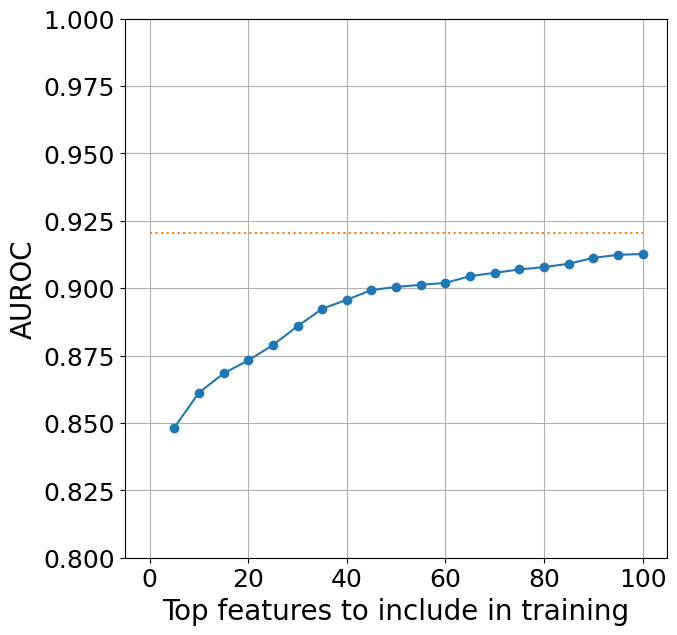

In [40]:
font = {'family' : 'normal', 'size'  : 18}
matplotlib.rc('font', **font)
plt.figure(figsize=(7, 7)) 
plt.xlabel("Top features to include in training", fontsize=20)
plt.ylabel("AUROC", fontsize=20)
plt.ylim(0.8, 1.0)
df = pd.DataFrame(auroc_performance.items(), columns=['x_axis', 'y_axis'])
plt.plot('x_axis', 'y_axis', data=df, linestyle='-', marker='o')
plt.plot([0, 100], [trtr_7_3_auroc, trtr_7_3_auroc], linestyle=':')  ## the performance of training on 70% real data and testing on 30% testing data
plt.grid()
plt.show()

In [41]:
for n, auroc in auroc_performance.items():
    print(n, auroc, auroc/trtr_7_3_auroc)

## select 95% performance as the threshold, thus 20 is the number of important features to achieve this.

5 0.8482502167557852 0.9216266481756866
10 0.8612122227644465 0.9357099103021436
15 0.8683702789161301 0.9434871618350232
20 0.8732087961319592 0.9487442266912163
25 0.878889034789373 0.9549158246599055
30 0.8858842370098798 0.9625161348613622
35 0.8923665089775497 0.969559144657429
40 0.8957079766931262 0.9731896603117276
45 0.8993320172135228 0.9771271922471042
50 0.9004492867115863 0.9783411092285197
55 0.9012864752755316 0.979250717354564
60 0.9019605796284202 0.979983133949339
65 0.9044961307877633 0.9827380186167437
70 0.905709654851692 0.9840565165003006
75 0.9069647456459705 0.9854201767729865
80 0.9078388347426958 0.9863698774491654
85 0.9090814431554759 0.9877199755733315
90 0.9112777459955183 0.990106265826918
95 0.9123718396416531 0.9912950021690483
100 0.9127174267176519 0.9916704836628506


In [97]:
feature_imp_score = []
TRTR_top_features = set(list(feature_importance_TRTR.keys())[:20])
for run in range(len(syn_data_list)):
    run += 1
    feature_importance_value = np.load(f'./result/TSTR_feature_importance_run_{run}.npy', allow_pickle=True).item()
    syn_top_imp_features = []
    for key, imp in feature_importance_value.items():
        syn_top_imp_features.append(key)
        if len(syn_top_imp_features) == 20:
            syn_top_imp_features = set(syn_top_imp_features)
            intersection_imp_features = TRTR_top_features.intersection(syn_top_imp_features)
            feature_imp_score.append(len(intersection_imp_features)/len(TRTR_top_features))
            break
utility_score['Feature importance'] = feature_imp_score
feature_imp_score

[1.0]

In [42]:
np.save('./result/utility_score.npy', utility_score)

## 2. Rank datasets and derive scores for selection

In [43]:
utility_score

{'Column-wise correlation': [np.float64(7.714727635338697)],
 'Latent cluster analysis': [-5.996766469604482],
 'Medical concept abundance': [np.float64(0.07553465078505685)],
 'Clinical knowledge violation': array([0.06551822]),
 'TSTR_auroc': [np.float64(0.894741112680723)],
 'TRTS_auroc': [np.float64(0.8815851668418317)]}

In [44]:
dataset_ranks = {}
for metric, score in utility_score.items():
    if metric not in ['TSTR_auroc', 'TRTS_auroc', 'Feature importance']:
        ranks = ss.rankdata(score).astype(int)
        dataset_ranks[metric] = list(ranks)
    else:
        ranks = len(syn_data_list) + 1 - ss.rankdata(score).astype(int)
        dataset_ranks[metric] = list(ranks)
    print(metric, ranks)
np.save('./result/utility_score_dataset_ranks.npy', dataset_ranks)
dataset_ranks

Column-wise correlation [1]
Latent cluster analysis [1]
Medical concept abundance [1]
Clinical knowledge violation [1]
TSTR_auroc [1]
TRTS_auroc [1]


{'Column-wise correlation': [np.int64(1)],
 'Latent cluster analysis': [np.int64(1)],
 'Medical concept abundance': [np.int64(1)],
 'Clinical knowledge violation': [np.int64(1)],
 'TSTR_auroc': [np.int64(1)],
 'TRTS_auroc': [np.int64(1)]}

In [45]:
pd.read_csv('/u/student/2024/cs24btnsr11002/2.0/saved_dataset/original_testing_data.csv')

,WHITE,BLACK,ASIAN,HISPANIC,UN,OTHER,DIE_1y,GENDER,008,008.5,...,985,987,988,989,990,994,AGE,BMI,DIASTOLIC,SYSTOLIC
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,51.0,20.3,86.0,133.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,34.0,27.3,83.0,104.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,63.0,24.4,82.0,131.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,35.0,33.9,60.0,130.0
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,63.0,29.0,80.0,126.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63321,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,66.0,30.5,57.0,111.0
63322,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,21.0,26.6,77.0,108.0
63323,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,86.0,20.5,74.0,168.0
63324,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,62.0,34.0,76.0,124.0
